# HR Analytics

Ashley O'Mahony | [ashleyomahony.com](http://ashleyomahony.com) | February 2019  

***

## Introduction

### Objectives

This case study aims to model the probability of attrition of each employee from the HR Analytics Dataset, [available on Kaggle](https://www.kaggle.com/lnvardanyan/hr-analytics). Its conclusions will allow the management to understand which factors urge the employees to leave the company and which changes should be made to avoid their departure.

All the files of this project are saved in a [GitHub repository](https://github.com/ashomah/HR-Analytics).

### Libraries

This project uses a set of libraries for data manipulation, plotting and modelling.

In [1]:
# Loading Libraries
import pandas as pd #Data Manipulation
import numpy as np #Data Manipulation

import matplotlib.pyplot as plt #Plotting
import seaborn as sns #Plotting
sns.set(style='white')

from sklearn import preprocessing #Preprocessing

from scipy.stats import skew, boxcox_normmax #Preprocessing
from scipy.special import boxcox1p #Preprocessing

from sklearn.model_selection import train_test_split #Train/Test Split
from sklearn.linear_model import LogisticRegression #Model

from sklearn.metrics import classification_report #Metrics
from sklearn.metrics import confusion_matrix #Metrics
from sklearn.metrics import accuracy_score #Metrics
from sklearn.metrics import roc_auc_score, roc_curve #ROC
from sklearn import model_selection #Cross Validation
from sklearn.feature_selection import RFE, RFECV #Feature Selection

### Data Loading

The dataset is stored in the [GitHub repository](https://github.com/ashomah/HR-Analytics) as a CSV file: `turnover.csv`. The file is loaded directly from the repository.

In [2]:
hr = pd.read_csv('turnover.csv')
hr.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years  sales  \
0                   3              0     1                      0  sales   
1                   6              0     1                      0  sales   
2                   4              0     1                      0  sales   
3                   5              0     1                      0  sales   
4                   3              0     1                      0  sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

---

## Data Preparation

### Variables Types and Definitions

The first stage of this analysis is to describe the dataset, understand the meaning of variable and perform the necessary adjustments to ensure that the data will be proceeded correctly during the Machine Learning process.

In [3]:
# Shape of the data frame
print('Rows:', hr.shape[0], '| Columns:', hr.shape[1])

Rows: 14999 | Columns: 10


In [5]:
# Describe each variable
def df_desc(df):
    import pandas as pd
    desc = pd.DataFrame({'dtype': df.dtypes,
                         'NAs': df.isna().sum(),
                         'Numerical': (df.dtypes != 'object') & (df.apply(lambda column: column == 0).sum() + df.apply(lambda column: column == 1).sum() != len(df)),
                         'Boolean': df.apply(lambda column: column == 0).sum() + df.apply(lambda column: column == 1).sum() == len(df),
                         'Categorical': df.dtypes == 'object',
                        })
    return desc

df_desc(hr)

dtype  NAs  Numerical  Boolean  Categorical
satisfaction_level     float64    0       True    False        False
last_evaluation        float64    0       True    False        False
number_project           int64    0       True    False        False
average_montly_hours     int64    0       True    False        False
time_spend_company       int64    0       True    False        False
Work_accident            int64    0      False     True        False
left                     int64    0      False     True        False
promotion_last_5years    int64    0      False     True        False
sales                   object    0      False    False         True
salary                  object    0      False    False         True

The dataset consists in 14,999 rows and 10 columns. Each row represents an employee, and each column contains one employee attribute. None of these attributes contains any NA. Two (2) of these attributes contain decimal numbers, three (3) contain integers, three (3) contain booleans, and two (2) contain categorical values.

In [6]:
# Summarize numercial variables
hr.describe()

satisfaction_level  last_evaluation  number_project  \
count        14999.000000     14999.000000    14999.000000   
mean             0.612834         0.716102        3.803054   
std              0.248631         0.171169        1.232592   
min              0.090000         0.360000        2.000000   
25%              0.440000         0.560000        3.000000   
50%              0.640000         0.720000        4.000000   
75%              0.820000         0.870000        5.000000   
max              1.000000         1.000000        7.000000   

       average_montly_hours  time_spend_company  Work_accident          left  \
count          14999.000000        14999.000000   14999.000000  14999.000000   
mean             201.050337            3.498233       0.144610      0.238083   
std               49.943099            1.460136       0.351719      0.425924   
min               96.000000            2.000000       0.000000      0.000000   
25%              156.000000            3.000000       0.000000      0.000000   
50%              200.000000            3.000000       0.000000      0.000000   
75%              245.000000            4.000000       0.000000      0.000000   
max              310.000000           10.000000       1.000000      1.000000   

       promotion_last_5years  
count           14999.000000  
mean                0.021268  
std                 0.144281  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 1.000000

In [7]:
# Lists values of categorical variables
categories = {'sales': hr['sales'].unique().tolist(),
 'salary':hr['salary'].unique().tolist()}
for i in sorted(categories.keys()):
    print(i+":")
    print(categories[i])
    if i != sorted(categories.keys())[-1] :print("\n")

salary:
['low', 'medium', 'high']


sales:
['sales', 'accounting', 'hr', 'technical', 'support', 'management', 'IT', 'product_mng', 'marketing', 'RandD']


The variable `sales` seems to represent the company departments. Thus, it will be renamed as `department`.

In [8]:
# Rename variable sales
hr = hr.rename(index=str, columns={'sales':'department'})

The dataset contains 10 variables with no NAs:

- `satisfaction_level`: numerical, decimal values between 0 and 1.  
  *Employee satisfaction level, from 0 to 1.*
  
  
- `last_evaluation`: numerical, decimal values between 0 and 1.  
  *Employee last evaluation score, from 0 to 1.*


- `number_project`: numerical, integer values between 2 and 7.  
  *Number of projects handled by the employee.*


- `average_montly_hours`: numerical, integer values between 96 and 310.  
  *Average monthly hours worked by the employee.*
  
  
- `time_spend_company`: numerical, integer values between 2 and 10.  
  *Number of years spent in the company by the employee.*
  
  
- `Work_acident`: encoded categorical, boolean.  
  *Flag indicating if the employee had a work accident.*
  
  
- `left`: encoded categorical, boolean.  
  *Flag indicating if the employee has left the company. This is the __target variable__ of the study, the one to be modelled.*
  
  
- `promotion_last_5years`: encoded categorical, boolean.  
  *Flag indicating if the employee has been promoting within the past 5 years.*


- `department`: categorical, 10 values. 
  *Department of the employee: Sales, Accounting, HR, Technical, Support, Management, IT, Product Management, Marketing, R&D.*
  
  
- `salary`: categorical, 3 values.  
  *Salary level of the employee: Low, Medium, High.*

### Exploratory Data Analysis

#### Target Proportion

The objective of this study is to build a model to predict the value of the variable `left`, based on the other variables available.

In [9]:
# Count occurences of each values in left
hr['left'].value_counts()

left
0    11428
1     3571
Name: count, dtype: int64

**23.8% of the employees listed in the dataset have left the company.**  

The dataset is not balanced, which might introduce some bias in the predictive model. It would be interesting to proceed to two (2) analyses, one with the imbalanced dataset and one with a dataset balanced using the Synthetic minority Oversampling Technique (SMOTE).

A closer look to the means of the variables allow to highlight the differences between the employees who left the company and those who stayed.

In [202]:
# Get the mean of each variable for the different values of left
hr.groupby('left').mean()

TypeError: agg function failed [how->mean,dtype->object]

Employees who left the company have:
- **a lower satisfaction level:** 0.44 vs 0.67.
- **higher average monthly working hours:** 207 vs 199.
- **a lower work accident ratio:** 0.05 vs 0.18.
- **a lower promotion rate:** 0.01 vs 0.03.

#### Correlation Analysis

A correlation analysis will allow to identify relationships between the dataset variables. A plot of their distributions highlighting the value of the target variable might also reveal some patterns.

In [ ]:
# Correlation Matrix
plt.figure(figsize=(12,8))
sns.heatmap(hr.corr(), cmap='RdBu', annot=True)
plt.tight_layout()

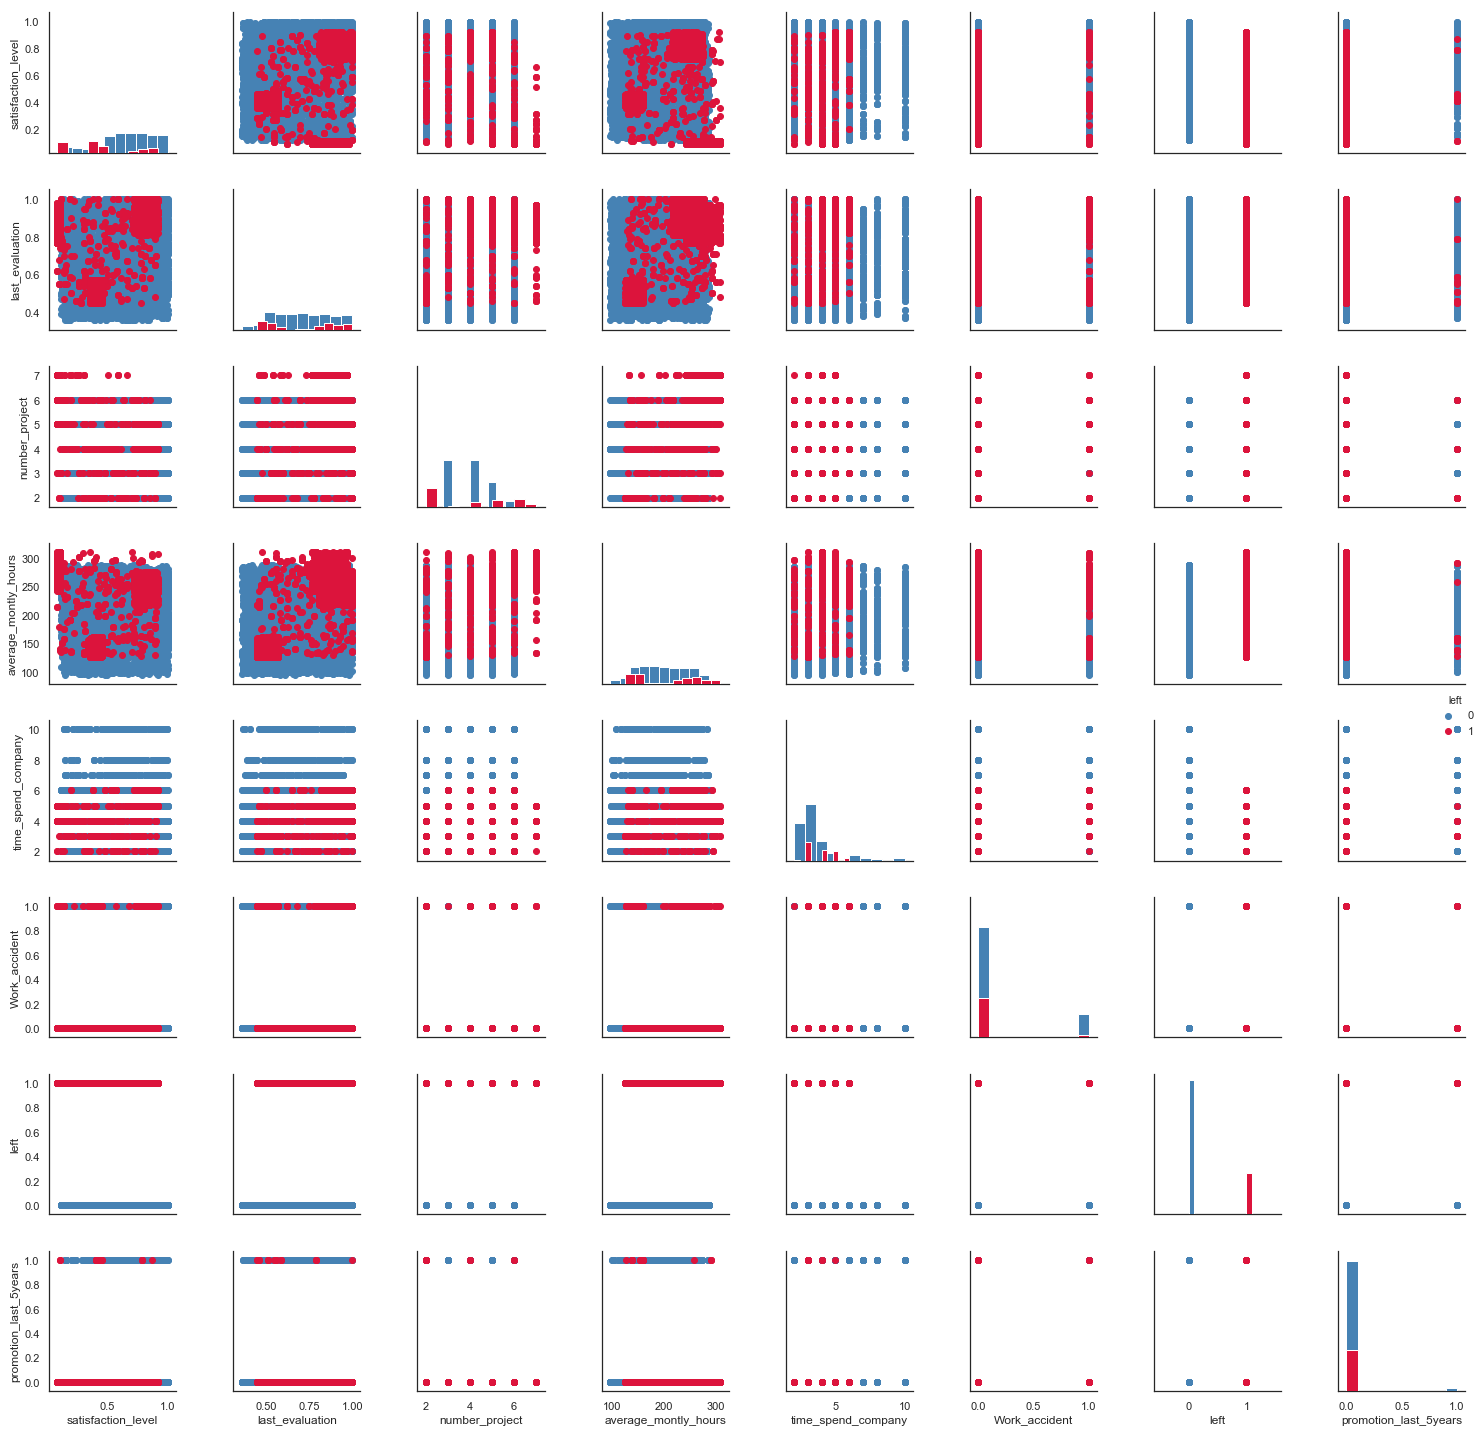

In [11]:
# Pair Plot
plot = sns.PairGrid(hr, hue='left', palette=('steelblue', 'crimson'))
plot = plot.map_diag(plt.hist)
plot = plot.map_offdiag(plt.scatter)
plot.add_legend()
plt.tight_layout()

No strong correlation appears in the dataset. However:
- `number_project` and `average_monthly_hours` have a **moderate positive** correlation (0.42).
- `left` and `satisfaction_level` have a **moderate negative** correlation (-0.39).
- `last_evaluation` and `number_project` have a **moderate positive** correlation (0.35).
- `last_evaluation` and `average_monthly_hours` have a **moderate positive** correlation (0.34).

#### Turnover by Salary Levels

In [11]:
# Salary Levels proportions and turnover rates
print('Salary Levels proportions')
print(hr['salary'].value_counts()/len(hr)*100)
print('\n')
print('Turnover Rate by Salary level')
print(hr.groupby('salary')['left'].mean())

Salary Levels proportions
salary
low       48.776585
medium    42.976198
high       8.247216
Name: count, dtype: float64


Turnover Rate by Salary level
salary
high      0.066289
low       0.296884
medium    0.204313
Name: left, dtype: float64


The salary level seems to have a **great impact** on the employee turnover, as higher salaries tend to stay in the company (7% of turnover), whereas lower salaries tend to leave the company (30% of turnover).

#### Turnover by Departments

In [12]:
# Departments proportions
hr['department'].value_counts()/len(hr)*100

department
sales          27.601840
technical      18.134542
support        14.860991
IT              8.180545
product_mng     6.013734
marketing       5.720381
RandD           5.247016
accounting      5.113674
hr              4.926995
management      4.200280
Name: count, dtype: float64

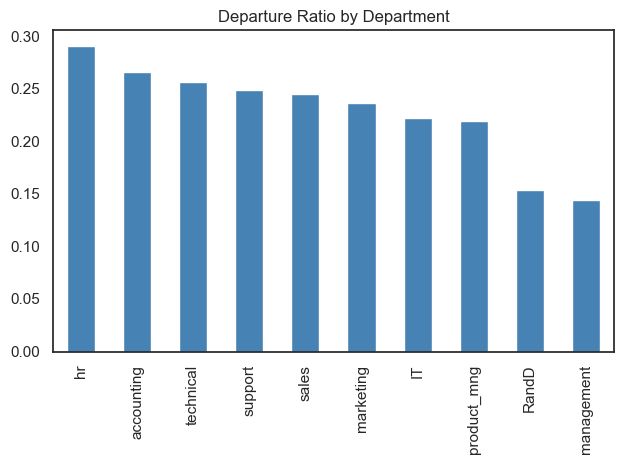

In [13]:
# Turnover Rate by Department
hr.groupby('department')['left'].mean().sort_values(ascending=False).plot(kind='bar', color='steelblue')
plt.title('Departure Ratio by Department')
plt.xlabel('')
plt.tight_layout()

Some observations can be inferred:
- Departure rate differs depending on the department, but **no clear outlier is detected**.
- HR has the **highest turnover rate**.
- R&D and Management have a **significantly lower turnover rate**.

#### Turnover by Satisfaction Level

C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


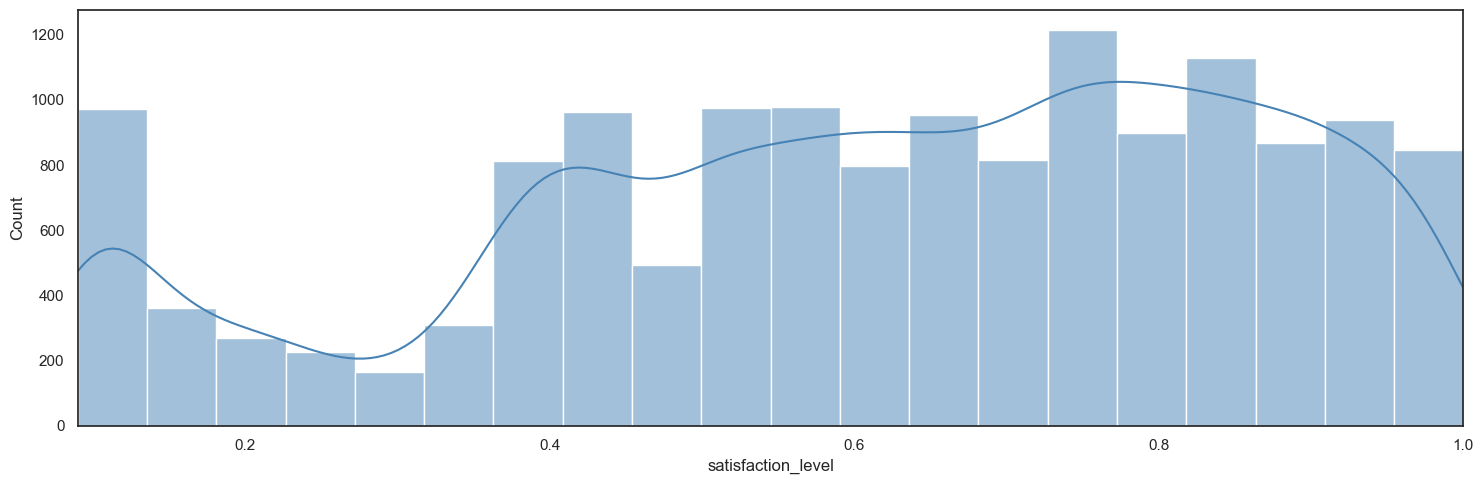

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Replace inf and -inf values with NaN
hr.replace([np.inf, -np.inf], np.nan, inplace=True)

# Bar Plot
plt.figure(figsize=(15, 5))

# Use histplot as the replacement for distplot
sns.histplot(hr['satisfaction_level'], 
             bins=20, 
             color='steelblue', 
             kde=True)  # kde=True adds the kernel density estimate

# Setting the x-axis limits based on the data
plt.xlim(min(hr['satisfaction_level']), max(hr['satisfaction_level']))

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()


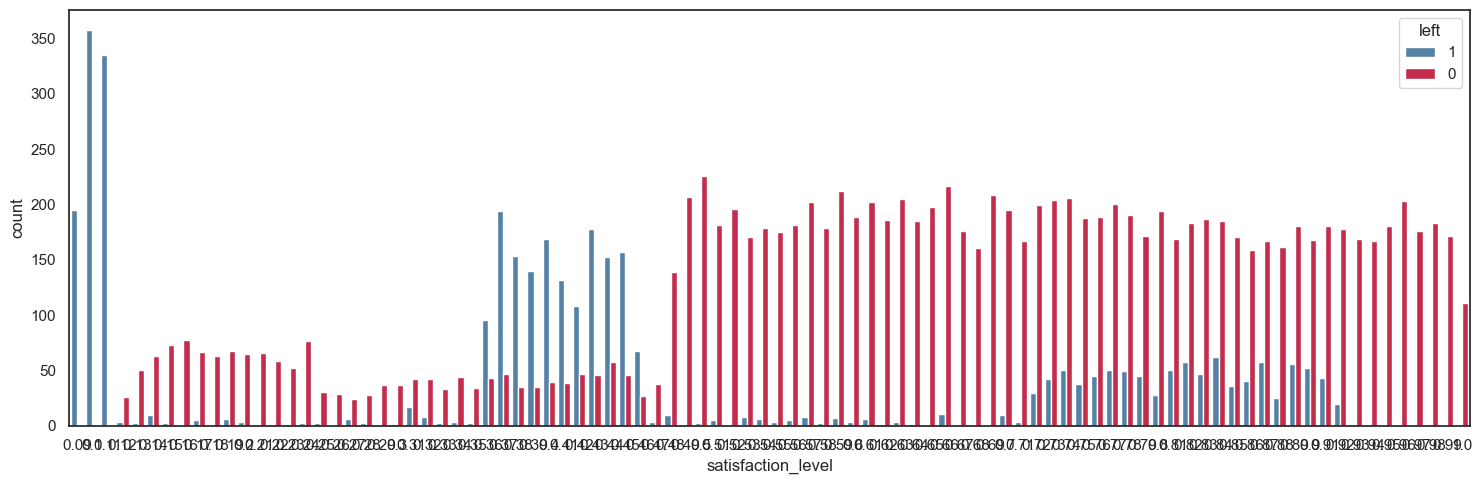

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'left' column is categorical
hr['left'] = hr['left'].astype(str)

# Bar Plot with left values
plt.figure(figsize=(15, 5))

# Specify 'satisfaction_level' on the x-axis
sns.countplot(x=hr['satisfaction_level'],   # Set satisfaction_level on the x-axis
              hue=hr['left'],               # Color bars by 'left' column
              palette=('steelblue', 'crimson'))  # Set color palette

plt.tight_layout()

# Display the plot
plt.show()


The Satisfaction Level shows 3 interesting areas:
- Employees leave the company *below 0.12*.
- There is a **high rate of departure between 0.36 and 0.46**.
- Turnover rate is **higher between 0.72 and 0.92**.

Employees with very low satisfaction level obviously leave the company. The risky zone is when employees rates their satisfaction just below 0.5. Employees also tend to leave the company when they become moderately satisfied.

#### Turnover by Last Evaluation

C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


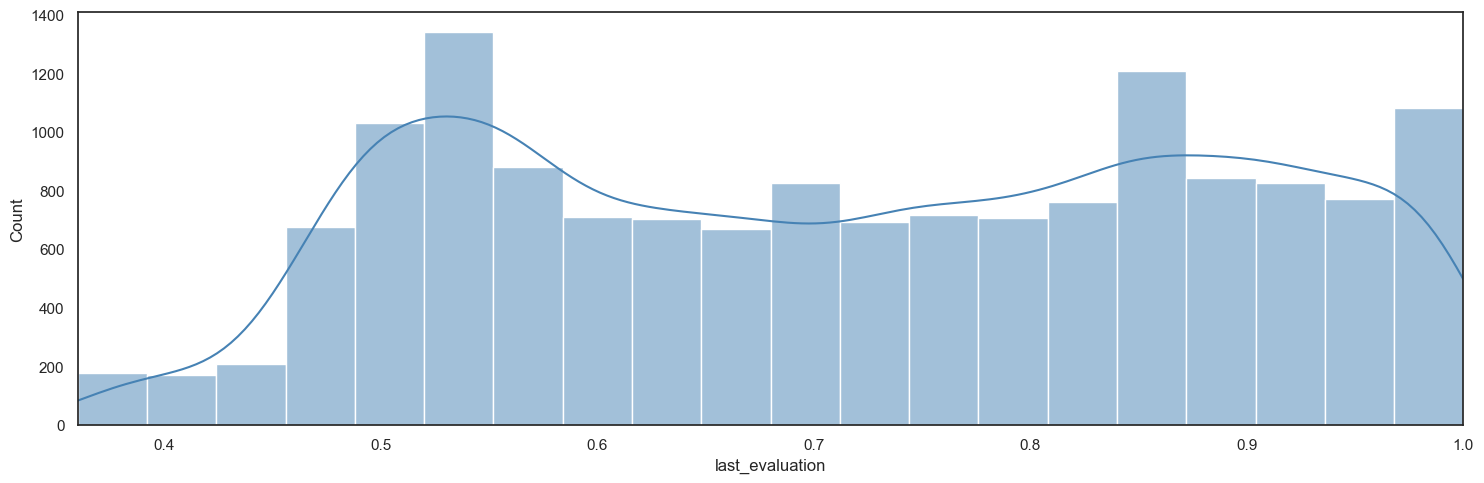

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Replace inf and -inf values with NaN
hr.replace([np.inf, -np.inf], np.nan, inplace=True)

# Bar Plot using histplot
plt.figure(figsize=(15, 5))

# Use histplot instead of distplot
sns.histplot(hr['last_evaluation'], 
             bins=20, 
             color='steelblue', 
             kde=True)  # kde=True adds the KDE line

# Set x-axis limits
plt.xlim(min(hr['last_evaluation']), max(hr['last_evaluation']))

plt.tight_layout()

# Display the plot
plt.show()


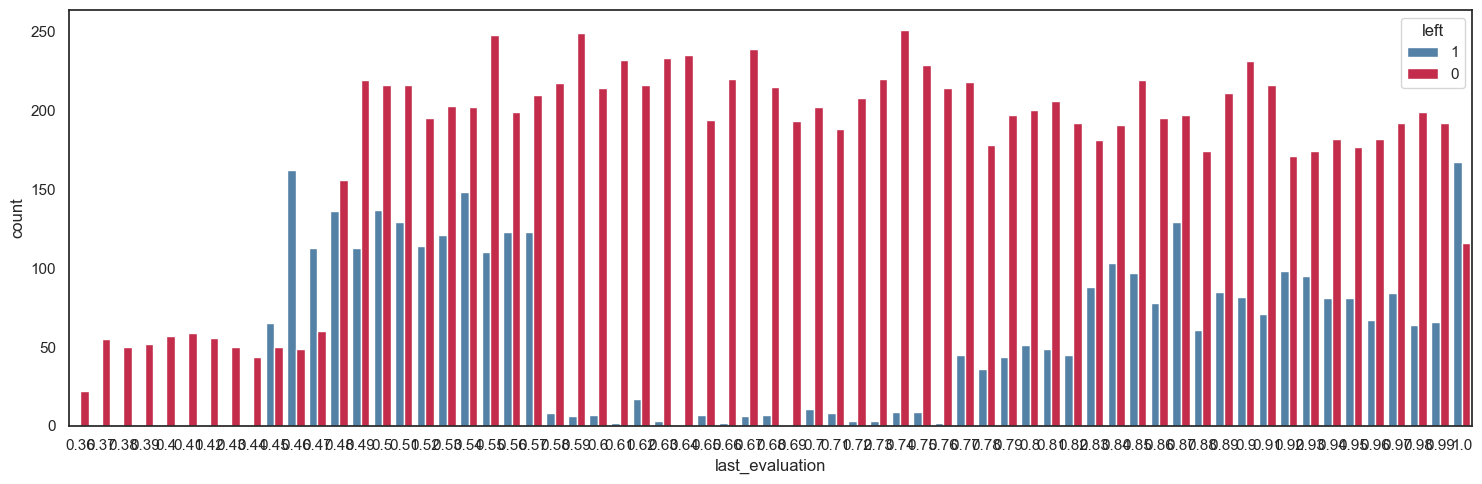

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar Plot with last_evaluation on the x-axis and 'left' as hue
plt.figure(figsize=(15, 5))

# Use countplot with x parameter specified
sns.countplot(x='last_evaluation', 
              hue='left', 
              data=hr, 
              palette=('steelblue', 'crimson'))

plt.tight_layout()

# Display the plot
plt.show()


The Last Evaluation shows 2 interesting areas:
- Turnover rate is **higher between 0.45 and 0.57**.
- Turnover rate is **higher above 0.77**.

Employees with low evaluation scores tend to leave the company. A large number of good employees leave the company, maybe to get a better opportunity. Interestingly, the ones with very low scores seem to stay.

#### Turnover by Number of Projects

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10708\475219217.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(hr.number_project,
C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


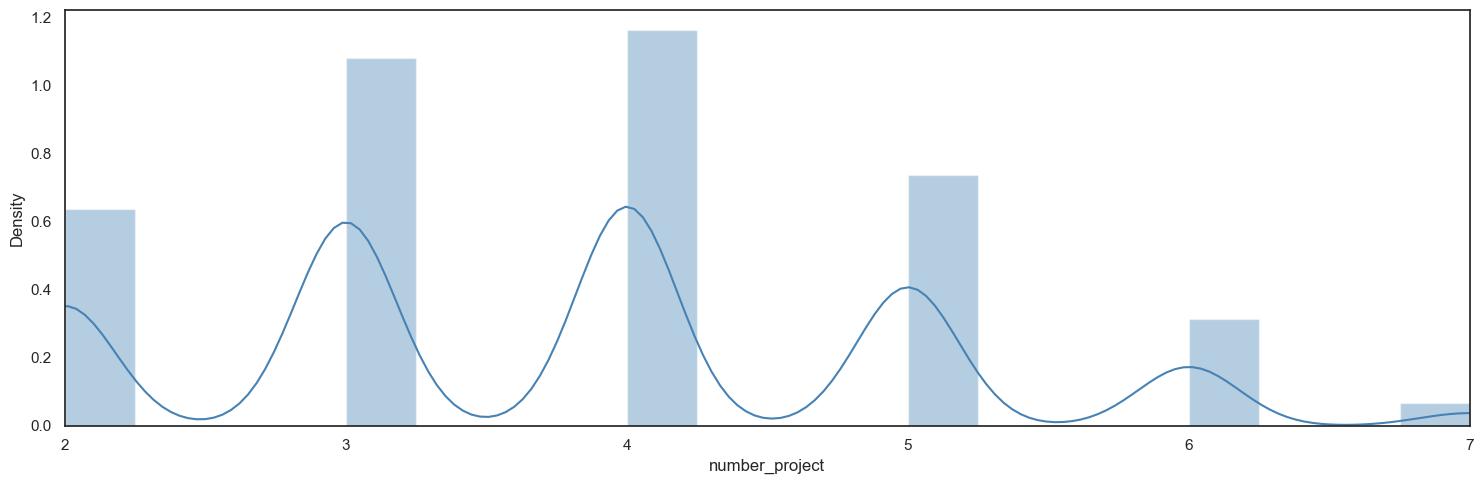

In [24]:
# Bar Plot
plt.figure(figsize=(15,5))
sns.distplot(hr.number_project,
             bins = 20,
             color = 'steelblue').axes.set_xlim(min(hr.number_project),max(hr.number_project))
plt.tight_layout()

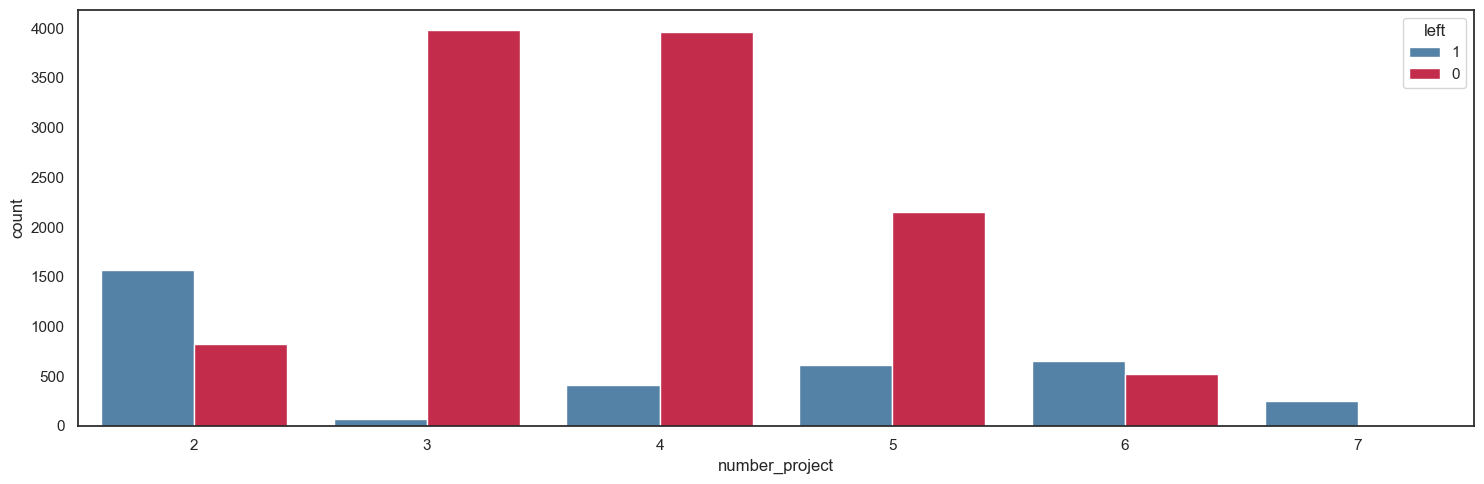

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar Plot with number_project on the x-axis and 'left' as hue
plt.figure(figsize=(15, 5))

# Use countplot with x parameter specified
sns.countplot(x='number_project', 
              hue='left', 
              data=hr, 
              palette=('steelblue', 'crimson'))

plt.tight_layout()

# Display the plot
plt.show()


The main observation regarding the number of projects is that employees with **only 2 or more than 5 projects** have a higher probability to leave the company.

#### Turnover by Average Monthly Hours

C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


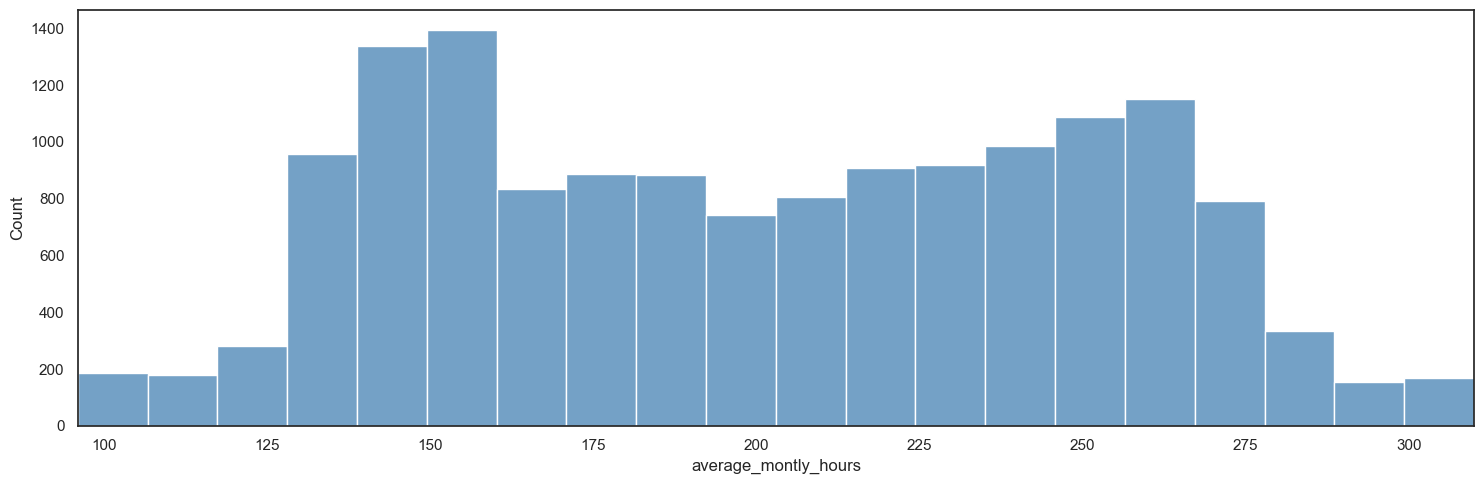

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Replace inf and -inf values with NaN
hr.replace([np.inf, -np.inf], np.nan, inplace=True)

# Bar Plot using histplot
plt.figure(figsize=(15, 5))

# Use histplot instead of distplot
sns.histplot(hr['average_montly_hours'], 
             bins=20, 
             color='steelblue', 
             kde=False)  # kde=False to not include the KDE line

# Set x-axis limits
plt.xlim(min(hr['average_montly_hours']), max(hr['average_montly_hours']))

plt.tight_layout()

# Display the plot
plt.show()


C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


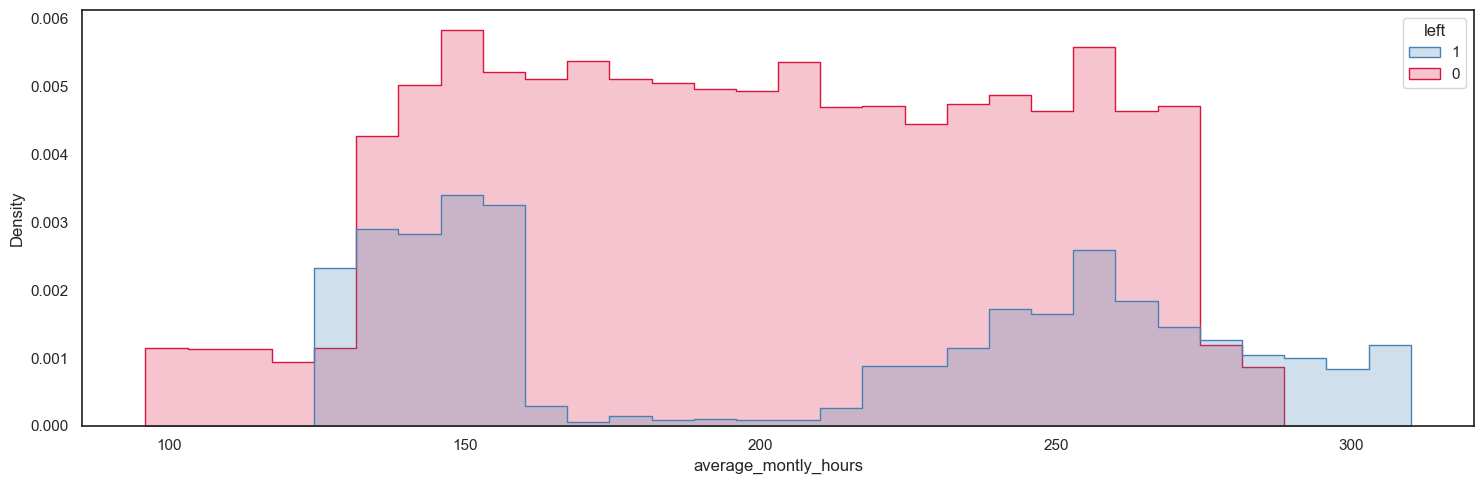

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'left' column is categorical if it's not already
hr['left'] = hr['left'].astype(str)

# Bar Plot with average_montly_hours and 'left' as hue
plt.figure(figsize=(15, 5))

# Use histplot to visualize the distribution
sns.histplot(data=hr, 
             x='average_montly_hours', 
             hue='left', 
             palette=('steelblue', 'crimson'), 
             bins=30, 
             element='step', 
             stat='density')

plt.tight_layout()

# Display the plot
plt.show()


The Average Monthly Hours shows 5 interesting areas:
- Turnover rate is **0% below 125 hours**.
- Turnover rate is **high between 126 and 161 hours**.
- Turnover rate is **moderate between 217 and 274 hours**.
- Turnover rate is **roughly around 50% between 275 and 287 hours**.
- Turnover rate is **100% above 288 hours**.

Employees with really low numbers of hours per month (below 125) tend to stay in the company, whereas employees working too many hours (above 275 hours) have a high probability to leave the company. **A 'safe' range is between 161 and 217 hours**, which seems to be ideal to keep employees in the company.

#### Turnover by Time Spent in the Company

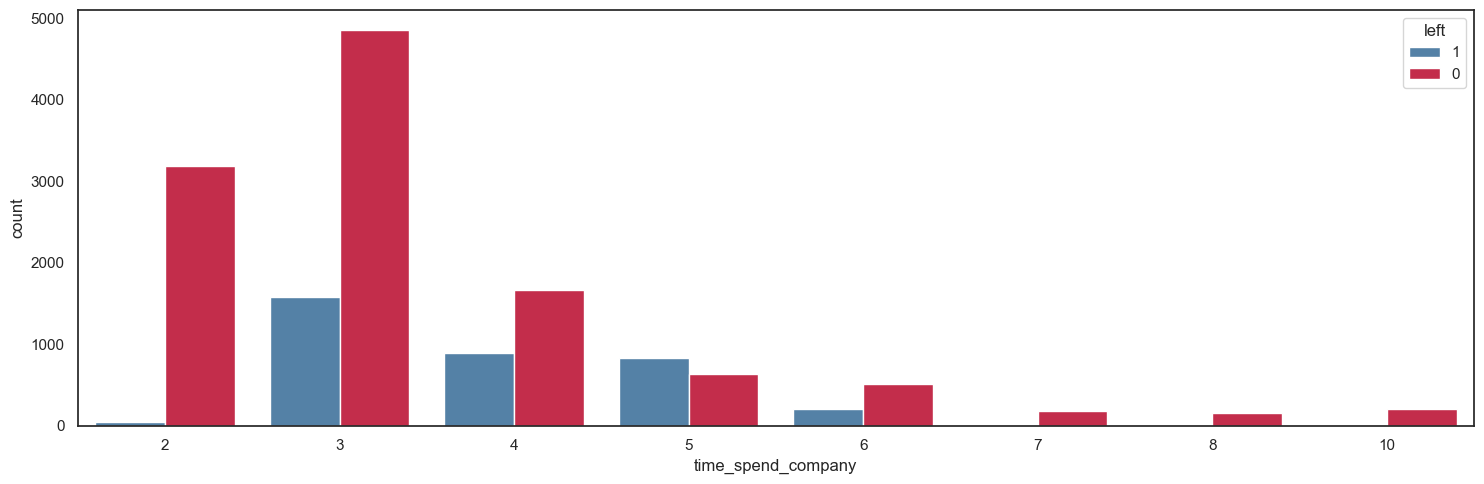

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'left' column is categorical if it's not already
hr['left'] = hr['left'].astype(str)

# Bar Plot with time_spend_company on the x-axis and 'left' as hue
plt.figure(figsize=(15, 5))

# Use countplot with x parameter specified
sns.countplot(x='time_spend_company', 
              hue='left', 
              data=hr, 
              palette=('steelblue', 'crimson'))

plt.tight_layout()

# Display the plot
plt.show()


It seems that employees with **3-6 years of services** are leaving the company.

#### Turnover by Work Accident

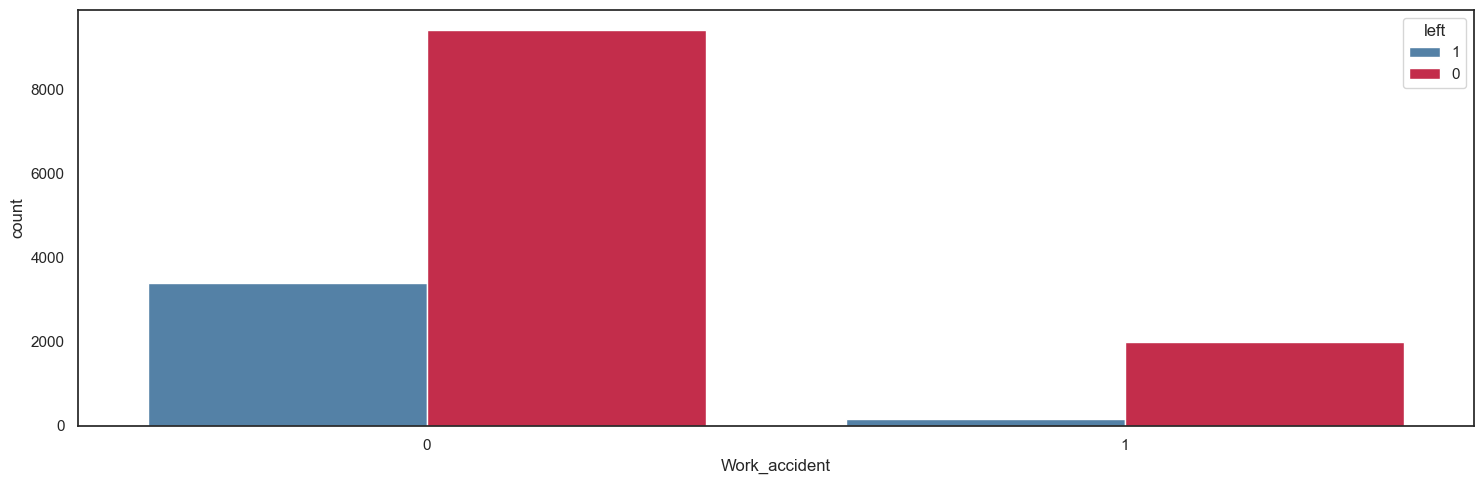

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'left' column is categorical if it's not already
hr['left'] = hr['left'].astype(str)

# Bar Plot with Work_accident on the x-axis and 'left' as hue
plt.figure(figsize=(15, 5))

# Use countplot with x parameter specified
sns.countplot(x='Work_accident', 
              hue='left', 
              data=hr, 
              palette=('steelblue', 'crimson'))

plt.tight_layout()

# Display the plot
plt.show()


Employees with a work accident tend to stay in the company.

#### Turnover by Promotion within the past 5 years

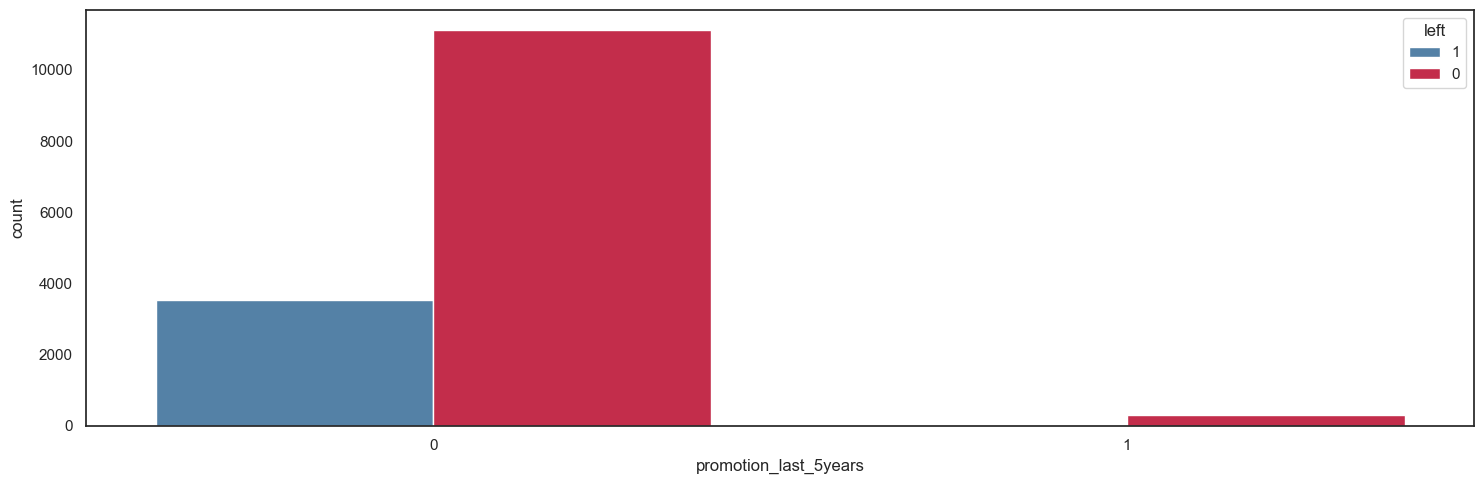

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'left' column is categorical if it's not already
hr['left'] = hr['left'].astype(str)

# Bar Plot with promotion_last_5years on the x-axis and 'left' as hue
plt.figure(figsize=(15, 5))

# Use countplot with x parameter specified
sns.countplot(x='promotion_last_5years', 
              hue='left', 
              data=hr, 
              palette=('steelblue', 'crimson'))

plt.tight_layout()

# Display the plot
plt.show()


In [33]:
print('Turnover Rate if Promotion:', round(len(hr[(hr['promotion_last_5years']==1)&(hr['left']==1)])/len(hr[(hr['promotion_last_5years']==1)])*100,2),'%')
print('Turnover Rate if No Promotion:', round(len(hr[(hr['promotion_last_5years']==0)&(hr['left']==1)])/len(hr[(hr['promotion_last_5years']==0)])*100,2),'%')

Turnover Rate if Promotion: 0.0 %
Turnover Rate if No Promotion: 0.0 %


It appears that employees with a promotion within the past 5 years have less propensity to leave the company.

#### Number of Projects vs Average Monthly Hours

C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


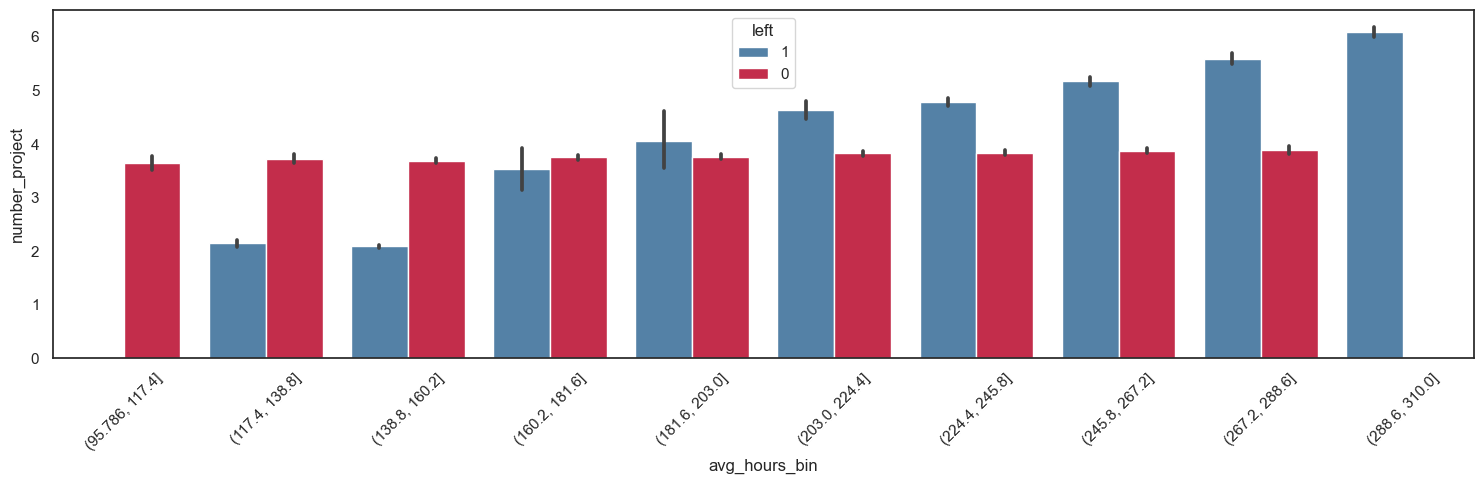

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert 'left' to categorical if it's not already
hr['left'] = hr['left'].astype(str)

# Create a new column for binned average_montly_hours
hr['avg_hours_bin'] = pd.cut(hr['average_montly_hours'], bins=10)

# Bar Plot with average_montly_hours bins and number_project as the value
plt.figure(figsize=(15, 5))

# Use barplot with aggregated data
sns.barplot(x='avg_hours_bin',
            y='number_project',
            hue='left',
            data=hr,
            palette=('steelblue', 'crimson'),
            estimator='mean')  # Compute the mean number_project for each bin

plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.tight_layout()

# Display the plot
plt.show()


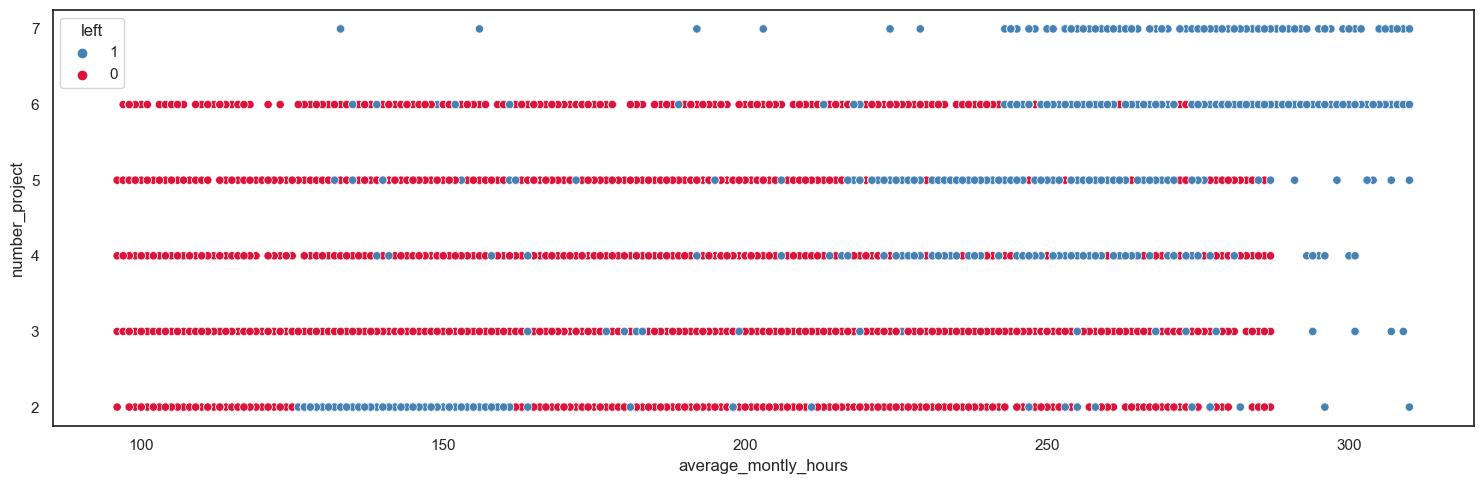

In [35]:
# Scatter Plot with left values
plt.figure(figsize=(15,5))
sns.scatterplot(x=hr.average_montly_hours,
            y=hr.number_project,
            hue=hr.left,
            palette = ('steelblue', 'crimson'))
plt.tight_layout()

It appears that:
- employees with **more than 4 projects** and working **more than 217 hours** tend to leave the company.
- employees with **less than 3 projects** and working **less than 161 hours** tend to leave the company.

A high or a low workload seem to push employees out.

#### Number of Projects vs Last Evaluation

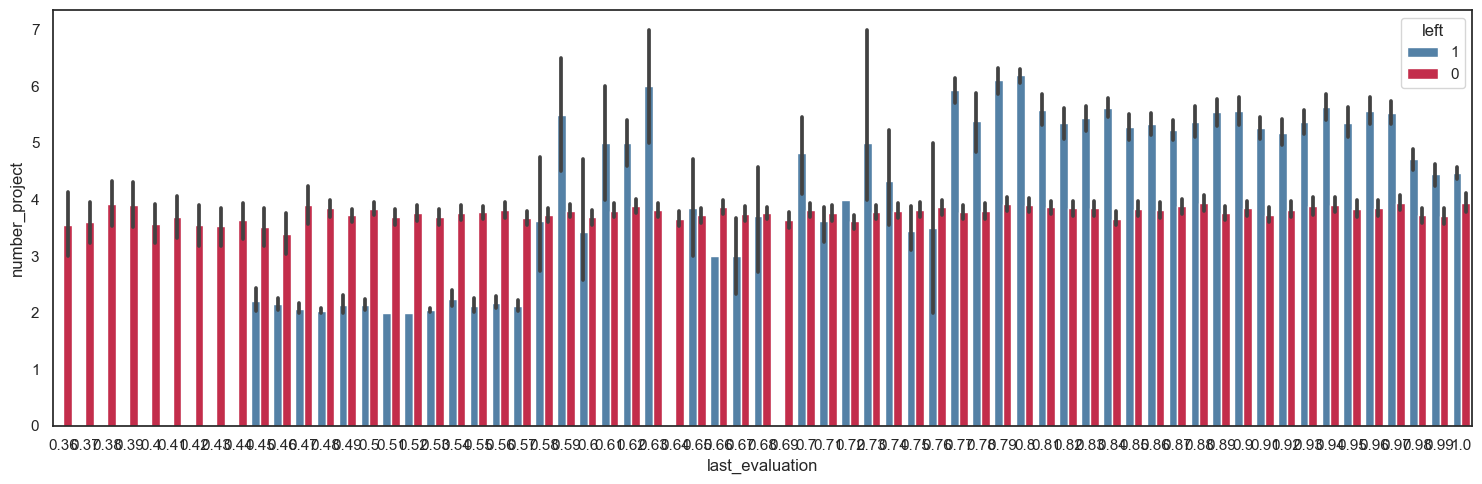

In [36]:
# Bar Plot with left values
plt.figure(figsize=(15,5))
sns.barplot(x=hr.last_evaluation,
            y=hr.number_project,
            hue=hr.left,
            palette = ('steelblue', 'crimson'))
plt.tight_layout()

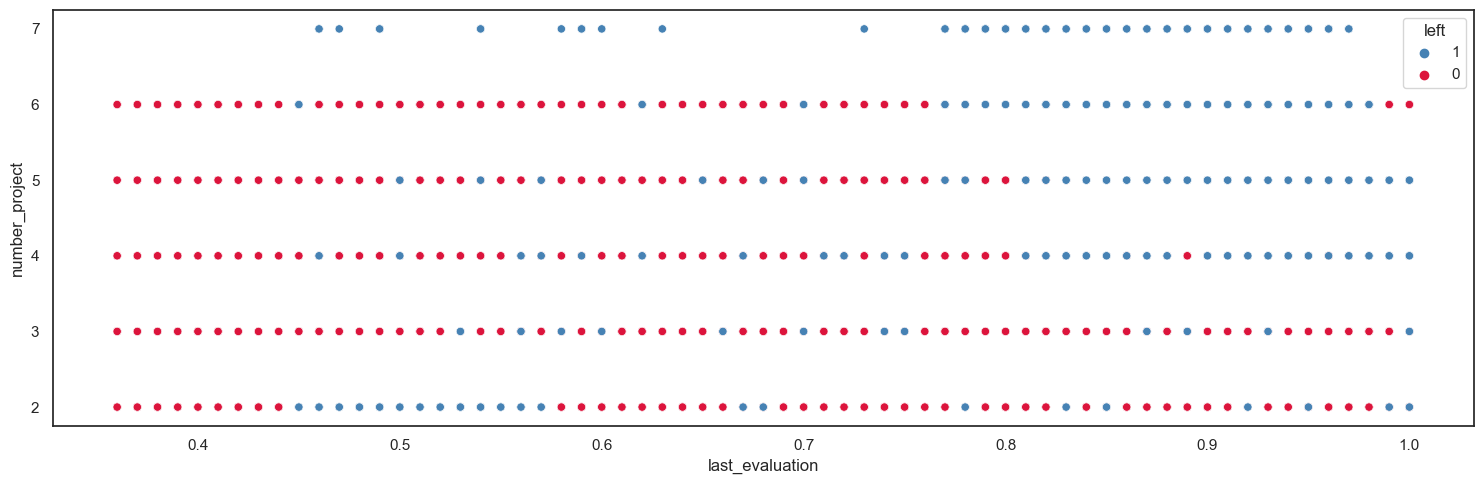

In [37]:
# Scatter Plot with left values
plt.figure(figsize=(15,5))
sns.scatterplot(x=hr.last_evaluation,
            y=hr.number_project,
            hue=hr.left,
            palette = ('steelblue', 'crimson'))
plt.tight_layout()

Employees with **more than 4 projects** seem to have **higher evaluations** but leave the company. Employees with **2 projects and a low evaluation** leave the company. 

#### Last Evaluation vs Average Monthly Hours

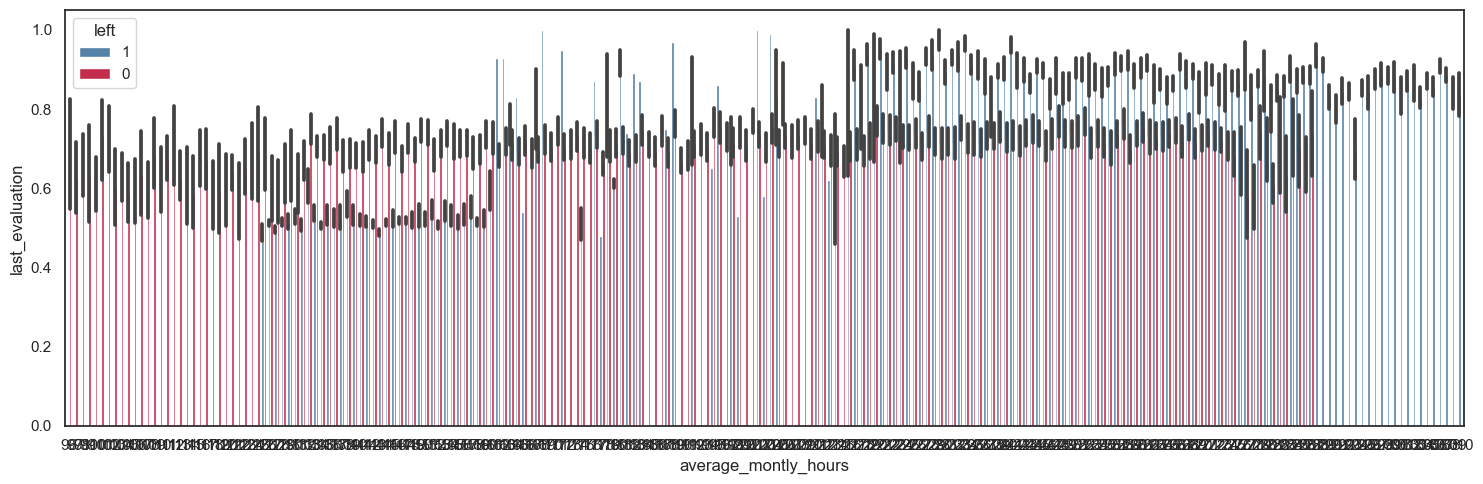

In [38]:
# Bar Plot with left values
plt.figure(figsize=(15,5))
sns.barplot(x=hr.average_montly_hours,
            y=hr.last_evaluation,
            hue=hr.left,
            palette = ('steelblue', 'crimson'))
plt.tight_layout()

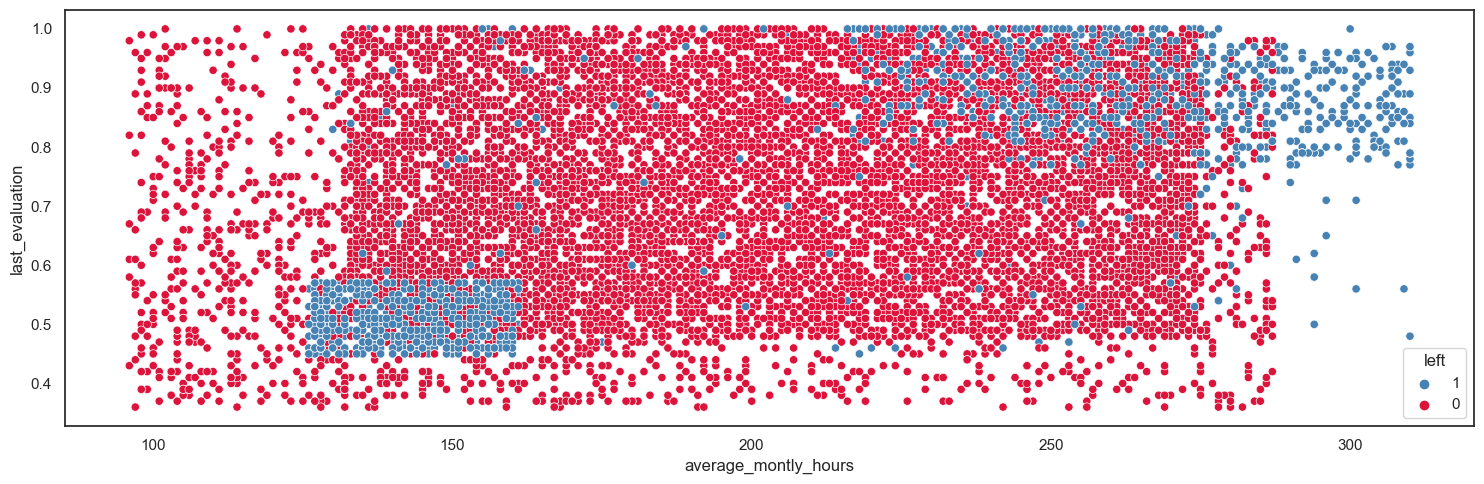

In [39]:
# Scatter Plot with left values
plt.figure(figsize=(15,5))
sns.scatterplot(x=hr.average_montly_hours,
            y=hr.last_evaluation,
            hue=hr.left,
            palette = ('steelblue', 'crimson'))
plt.tight_layout()

Employees with **high evaluation** and working **more than 217 hours** tend to leave the company. Employees with **evaluation around 0.5** and working **between 125 and 161 hours** tend to leave the company.

#### Last Evaluation vs Satisfaction Level

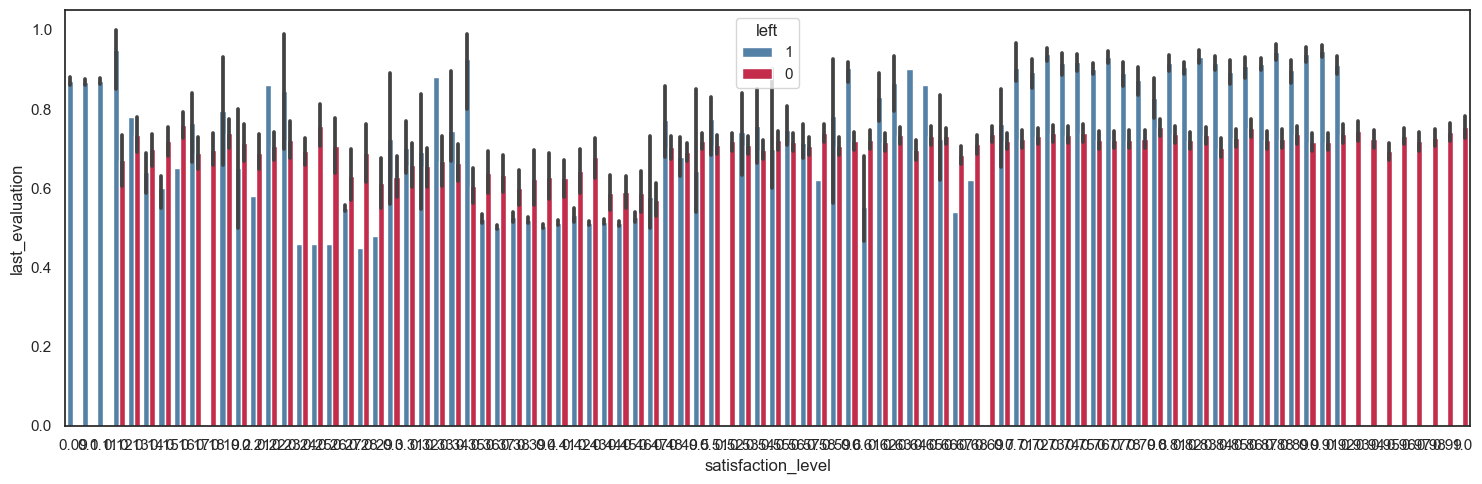

In [40]:
# Bar Plot with left values
plt.figure(figsize=(15,5))
sns.barplot(x=hr.satisfaction_level,
            y=hr.last_evaluation,
            hue=hr.left,
            palette = ('steelblue', 'crimson'))
plt.tight_layout()

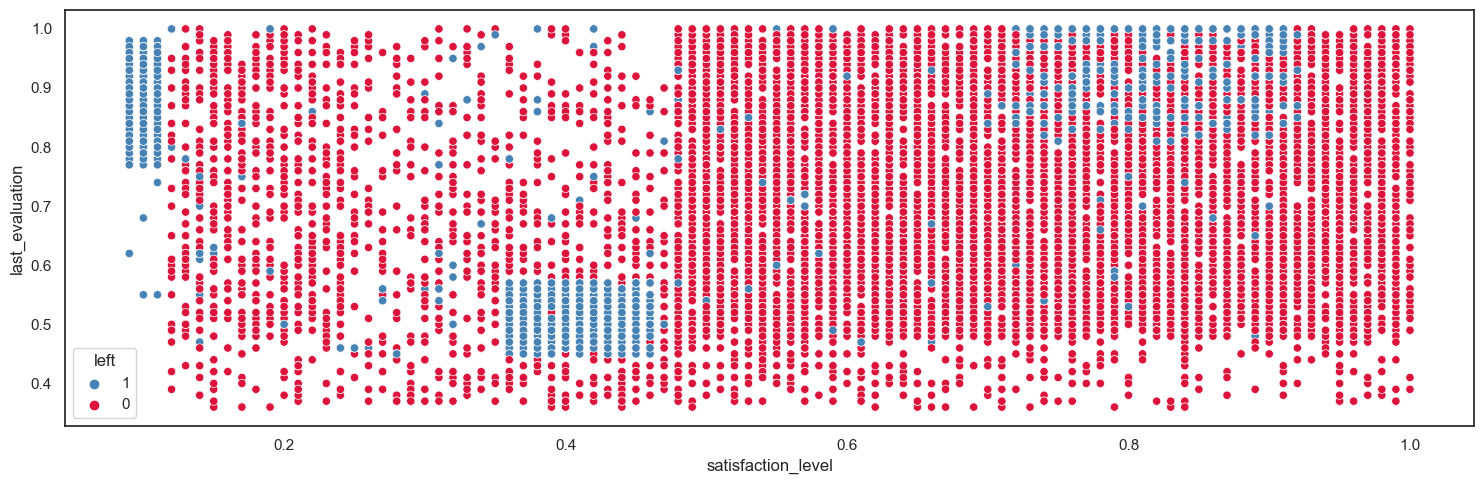

In [41]:
# Scatter Plot with left values
plt.figure(figsize=(15,5))
sns.scatterplot(x=hr.satisfaction_level,
            y=hr.last_evaluation,
            hue=hr.left,
            palette = ('steelblue', 'crimson'))
plt.tight_layout()

Employees with **satisfaction level below 0.11** tend to leave the company. Employees with **satisfaction level between 0.35 and 0.46** and with **last evaluation between 0.44 and 0.57** tend to leave the company. Employees with **satisfaction level between 0.71 and 0.92** and with **last evaluation between 0.76 and 1** tend to leave the company.

### Encoding Categorical Variables

The variable `salary` will be encoded using ordinal encoding and `department` will be encoded using one-hot encoding.

In [42]:
# Encoding the variable salary
salary_dict = {'low':0,'medium':1,'high':2}
hr['salary_num'] = hr.salary.map(salary_dict)
hr.drop('salary', inplace=True, axis=1)
hr = hr.rename(index=str, columns={'salary_num':'salary'})
hr.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident left  promotion_last_5years department  \
0                   3              0    1                      0      sales   
1                   6              0    1                      0      sales   
2                   4              0    1                      0      sales   
3                   5              0    1                      0      sales   
4                   3              0    1                      0      sales   

    avg_hours_bin  salary  
0  (138.8, 160.2]       0  
1  (245.8, 267.2]       1  
2  (267.2, 288.6]       1  
3  (203.0, 224.4]       0  
4  (138.8, 160.2]       0

In [43]:
def numerical_features(df):
    columns = df.columns
    return df._get_numeric_data().columns

def categorical_features(df):
    numerical_columns = numerical_features(df)
    return(list(set(df.columns) - set(numerical_columns)))

def onehot_encode(df):
    numericals = df.get(numerical_features(df))
    new_df = numericals.copy()
    for categorical_column in categorical_features(df):
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    return new_df

In [44]:
hr_encoded = onehot_encode(hr)
hr_encoded.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  promotion_last_5years  salary  \
0                   3              0                      0       0   
1                   6              0                      0       1   
2                   4              0                      0       1   
3                   5              0                      0       0   
4                   3              0                      0       0   

   avg_hours_bin_(95.786, 117.4]  avg_hours_bin_(117.4, 138.8]  ...  \
0                          False                         False  ...   
1                          False                         False  ...   
2                          False                         False  ...   
3                          False                         False  ...   
4                          False                         False  ...   

   department_IT  department_RandD  department_accounting  department_hr  \
0          False             False                  False          False   
1          False             False                  False          False   
2          False             False                  False          False   
3          False             False                  False          False   
4          False             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
1                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
1              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False  

[5 rows x 30 columns]

In [38]:
df_desc(hr_encoded)

dtype  NAs  Numerical  Boolean  Categorical
satisfaction_level      float64    0       True    False        False
last_evaluation         float64    0       True    False        False
number_project            int64    0       True    False        False
average_montly_hours      int64    0       True    False        False
time_spend_company        int64    0       True    False        False
Work_accident             int64    0      False     True        False
left                      int64    0      False     True        False
promotion_last_5years     int64    0      False     True        False
salary                    int64    0       True    False        False
department_IT             uint8    0      False     True        False
department_RandD          uint8    0      False     True        False
department_accounting     uint8    0      False     True        False
department_hr             uint8    0      False     True        False
department_management     uint8    0      False     True        False
department_marketing      uint8    0      False     True        False
department_product_mng    uint8    0      False     True        False
department_sales          uint8    0      False     True        False
department_support        uint8    0      False     True        False
department_technical      uint8    0      False     True        False

### Scaling and Skewness

Numerical variables `average_monthly_hours`, `last_evaluation` and `satisfaction_level` are scaled to remove any influence of their difference in value ranges on the model.

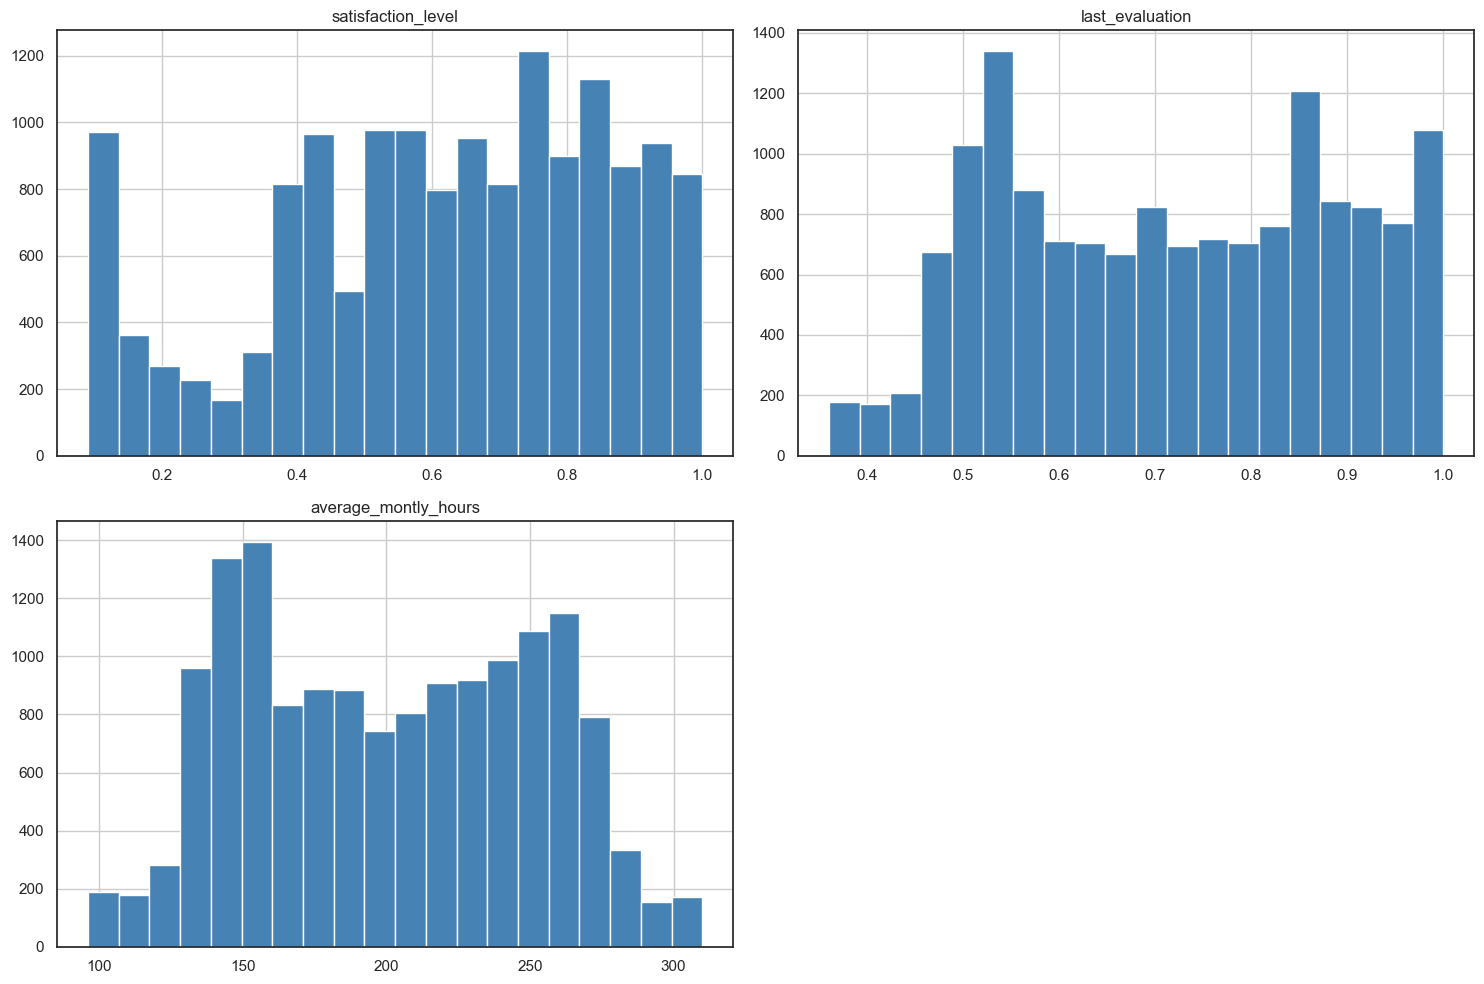

In [45]:
hr_encoded[['satisfaction_level',
           'last_evaluation',
           'average_montly_hours'
           ]].hist(bins = 20, figsize = (15,10), color = 'steelblue')
plt.tight_layout()

In [46]:
hr_encoded[['satisfaction_level',
           'last_evaluation',
           'average_montly_hours'
           ]].describe()

satisfaction_level  last_evaluation  average_montly_hours
count        14999.000000     14999.000000          14999.000000
mean             0.612834         0.716102            201.050337
std              0.248631         0.171169             49.943099
min              0.090000         0.360000             96.000000
25%              0.440000         0.560000            156.000000
50%              0.640000         0.720000            200.000000
75%              0.820000         0.870000            245.000000
max              1.000000         1.000000            310.000000

In [47]:
scaler = preprocessing.MinMaxScaler()
hr_scaled_part = scaler.fit_transform(hr_encoded[['satisfaction_level',
                                                  'last_evaluation',
                                                  'average_montly_hours']])
hr_scaled_part = pd.DataFrame(hr_scaled_part, columns=list(['satisfaction_level',
                                                  'last_evaluation',
                                                  'average_montly_hours']))

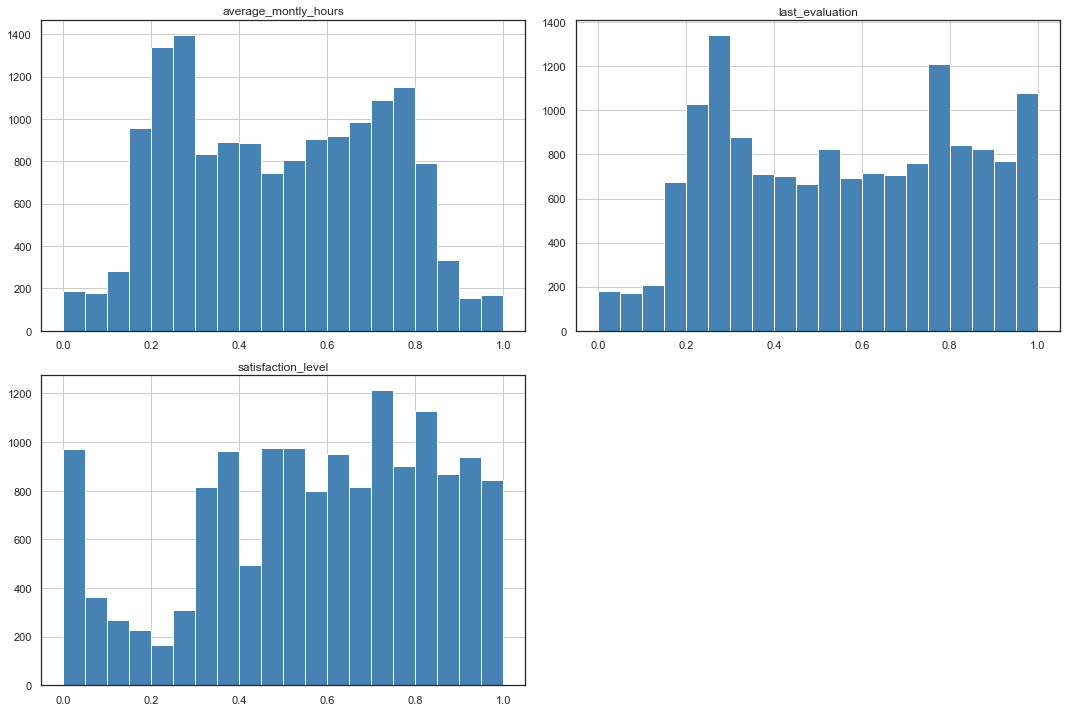

In [42]:
hr_scaled_part[['satisfaction_level',
                'last_evaluation',
                'average_montly_hours']].hist(bins = 20, figsize = (15,10), color = 'steelblue')
plt.tight_layout()

In [48]:
hr_scaled_part.describe()

satisfaction_level  last_evaluation  average_montly_hours
count        14999.000000     14999.000000          14999.000000
mean             0.574542         0.556409              0.490889
std              0.273220         0.267452              0.233379
min              0.000000         0.000000              0.000000
25%              0.384615         0.312500              0.280374
50%              0.604396         0.562500              0.485981
75%              0.802198         0.796875              0.696262
max              1.000000         1.000000              1.000000

The skewness of the scaled variables is then fixed.

In [49]:
def feature_skewness(df):
    numeric_dtypes = ['int16', 'int32', 'int64', 
                      'float16', 'float32', 'float64']
    numeric_features = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes: 
            numeric_features.append(i)

    feature_skew = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':feature_skew})
    return feature_skew, numeric_features

In [50]:
def fix_skewness(df):
    feature_skew, numeric_features = feature_skewness(df)
    high_skew = feature_skew[feature_skew > 0.5]
    skew_index = high_skew.index
    
    for i in skew_index:
        df[i] = boxcox1p(df[i], boxcox_normmax(df[i]+1))

    skew_features = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':skew_features})
    return df

In [51]:
hr_skewed_part = fix_skewness(hr_scaled_part)

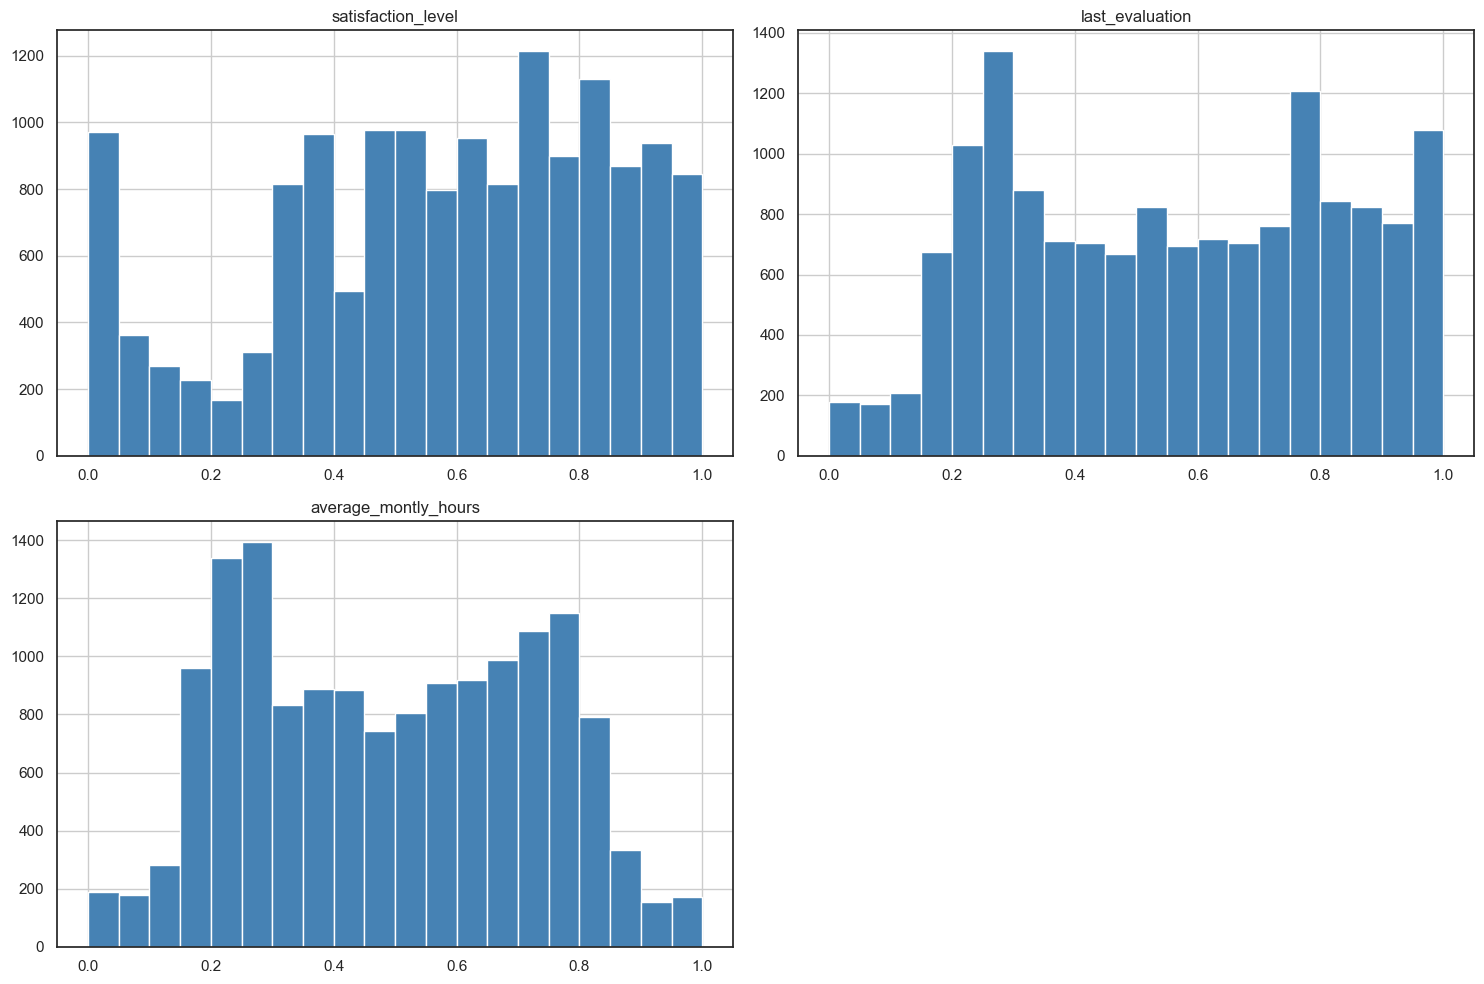

In [52]:
hr_skewed_part.hist(bins = 20, figsize = (15,10), color = 'steelblue')
plt.tight_layout()

In [53]:
hr_skewed_part.describe()

satisfaction_level  last_evaluation  average_montly_hours
count        14999.000000     14999.000000          14999.000000
mean             0.574542         0.556409              0.490889
std              0.273220         0.267452              0.233379
min              0.000000         0.000000              0.000000
25%              0.384615         0.312500              0.280374
50%              0.604396         0.562500              0.485981
75%              0.802198         0.796875              0.696262
max              1.000000         1.000000              1.000000

The resulting values aren't different than the initial ones, showing that the data wasn't skewed.

In [54]:
hr_simple = hr_encoded.copy()
hr_simple.drop(['satisfaction_level',
                'last_evaluation',
                'average_montly_hours'], inplace=True, axis=1)

hr_ready = pd.DataFrame()
hr_simple.reset_index(drop=True, inplace=True)
hr_skewed_part.reset_index(drop=True, inplace=True)

hr_ready = pd.concat([hr_skewed_part,hr_simple], axis=1, sort=False, ignore_index=False)

# hr_ready['number_project'] = hr_ready['number_project'].astype('category').cat.codes
# hr_ready['time_spend_company'] = hr_ready['time_spend_company'].astype('category').cat.codes

hr_ready.head()

satisfaction_level  last_evaluation  average_montly_hours  number_project  \
0            0.318681         0.265625              0.285047               2   
1            0.780220         0.781250              0.775701               5   
2            0.021978         0.812500              0.822430               7   
3            0.692308         0.796875              0.593458               5   
4            0.307692         0.250000              0.294393               2   

   time_spend_company  Work_accident  promotion_last_5years  salary  \
0                   3              0                      0       0   
1                   6              0                      0       1   
2                   4              0                      0       1   
3                   5              0                      0       0   
4                   3              0                      0       0   

   avg_hours_bin_(95.786, 117.4]  avg_hours_bin_(117.4, 138.8]  ...  \
0                          False                         False  ...   
1                          False                         False  ...   
2                          False                         False  ...   
3                          False                         False  ...   
4                          False                         False  ...   

   department_IT  department_RandD  department_accounting  department_hr  \
0          False             False                  False          False   
1          False             False                  False          False   
2          False             False                  False          False   
3          False             False                  False          False   
4          False             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
1                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
1              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False  

[5 rows x 30 columns]

In [55]:
df_desc(hr_ready)

dtype  NAs  Numerical  Boolean  Categorical
satisfaction_level             float64    0       True    False        False
last_evaluation                float64    0       True    False        False
average_montly_hours           float64    0       True    False        False
number_project                   int64    0       True    False        False
time_spend_company               int64    0       True    False        False
Work_accident                    int64    0      False     True        False
promotion_last_5years            int64    0      False     True        False
salary                           int64    0       True    False        False
avg_hours_bin_(95.786, 117.4]     bool    0      False     True        False
avg_hours_bin_(117.4, 138.8]      bool    0      False     True        False
avg_hours_bin_(138.8, 160.2]      bool    0      False     True        False
avg_hours_bin_(160.2, 181.6]      bool    0      False     True        False
avg_hours_bin_(181.6, 203.0]      bool    0      False     True        False
avg_hours_bin_(203.0, 224.4]      bool    0      False     True        False
avg_hours_bin_(224.4, 245.8]      bool    0      False     True        False
avg_hours_bin_(245.8, 267.2]      bool    0      False     True        False
avg_hours_bin_(267.2, 288.6]      bool    0      False     True        False
avg_hours_bin_(288.6, 310.0]      bool    0      False     True        False
left_0                            bool    0      False     True        False
left_1                            bool    0      False     True        False
department_IT                     bool    0      False     True        False
department_RandD                  bool    0      False     True        False
department_accounting             bool    0      False     True        False
department_hr                     bool    0      False     True        False
department_management             bool    0      False     True        False
department_marketing              bool    0      False     True        False
department_product_mng            bool    0      False     True        False
department_sales                  bool    0      False     True        False
department_support                bool    0      False     True        False
department_technical              bool    0      False     True        False

In [56]:
hr_ready.describe()

satisfaction_level  last_evaluation  average_montly_hours  \
count        14999.000000     14999.000000          14999.000000   
mean             0.574542         0.556409              0.490889   
std              0.273220         0.267452              0.233379   
min              0.000000         0.000000              0.000000   
25%              0.384615         0.312500              0.280374   
50%              0.604396         0.562500              0.485981   
75%              0.802198         0.796875              0.696262   
max              1.000000         1.000000              1.000000   

       number_project  time_spend_company  Work_accident  \
count    14999.000000        14999.000000   14999.000000   
mean         3.803054            3.498233       0.144610   
std          1.232592            1.460136       0.351719   
min          2.000000            2.000000       0.000000   
25%          3.000000            3.000000       0.000000   
50%          4.000000            3.000000       0.000000   
75%          5.000000            4.000000       0.000000   
max          7.000000           10.000000       1.000000   

       promotion_last_5years        salary  
count           14999.000000  14999.000000  
mean                0.021268      0.594706  
std                 0.144281      0.637183  
min                 0.000000      0.000000  
25%                 0.000000      0.000000  
50%                 0.000000      1.000000  
75%                 0.000000      1.000000  
max                 1.000000      2.000000

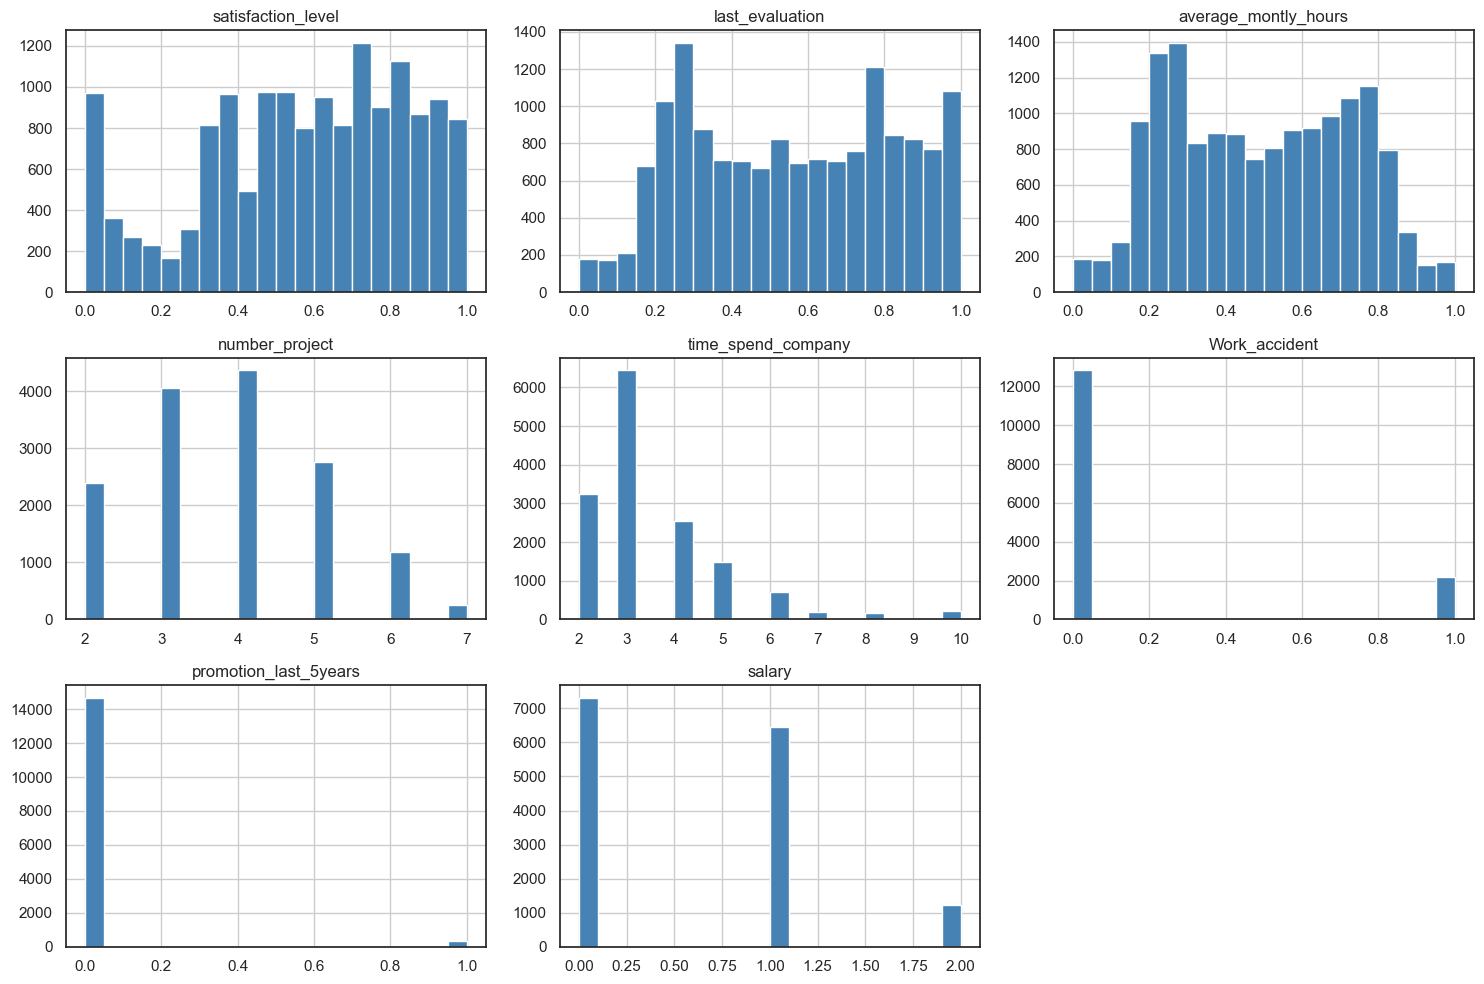

In [57]:
hr_ready.hist(bins = 20, figsize = (15,10), color = 'steelblue')
plt.tight_layout()

The dataset is now ready to go through the baseline and feature engineering phases.

### Training/Test Split

The model target `left` is defined, taking all other variables as features. The dataset is split in a train set and a test set, using a random split with ratio 70|30.

In [60]:
print("Available columns:", hr_ready.columns)

Available columns: Index(['satisfaction_level', 'last_evaluation', 'average_montly_hours',
       'number_project', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'salary', 'avg_hours_bin_(95.786, 117.4]',
       'avg_hours_bin_(117.4, 138.8]', 'avg_hours_bin_(138.8, 160.2]',
       'avg_hours_bin_(160.2, 181.6]', 'avg_hours_bin_(181.6, 203.0]',
       'avg_hours_bin_(203.0, 224.4]', 'avg_hours_bin_(224.4, 245.8]',
       'avg_hours_bin_(245.8, 267.2]', 'avg_hours_bin_(267.2, 288.6]',
       'avg_hours_bin_(288.6, 310.0]', 'left_0', 'left_1', 'department_IT',
       'department_RandD', 'department_accounting', 'department_hr',
       'department_management', 'department_marketing',
       'department_product_mng', 'department_sales', 'department_support',
       'department_technical'],
      dtype='object')


In [61]:
target = 'correct_column_name'  # Replace with the correct column name


In [199]:
# Print the available columns in the DataFrame
print("Available columns in hr_ready:", hr_ready.columns)

# Replace 'correct_column_name' with an actual column name from the output
target = 'left_1'  # Example column name, make sure it matches an actual column in hr_ready

# Define the function for splitting the dataset
def split_dataset(df, target, split_ratio=0.3, seed=806):
    if target not in df.columns:
        raise ValueError(f"Target column '{target}' not found in DataFrame columns.")
    
    features = list(df.columns)
    features.remove(target)

    X = df[features]
    y = df[[target]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio, random_state=seed)

    return X, y, X_train, X_test, y_train, y_test

# Apply the function
X, y, X_train, X_test, y_train, y_test = split_dataset(hr_ready, target, split_ratio, seed)

# Print dataset details
print('Features:', X.shape[0], 'items |', X.shape[1], 'columns')
print('Target:', y.shape[0], 'items |', y.shape[1], 'columns')
print('Features Train:', X_train.shape[0], 'items |', X_train.shape[1], 'columns')
print('Features Test:', X_test.shape[0], 'items |', X_test.shape[1], 'columns')
print('Target Train:', y_train.shape[0], 'items |', y_train.shape[1], 'columns')
print('Target Test:', y_test.shape[0], 'items |', y_test.shape[1], 'columns')


Available columns in hr_ready: Index(['satisfaction_level', 'last_evaluation', 'average_montly_hours',
       'number_project', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'salary', 'avg_hours_bin_(95.786, 117.4]',
       'avg_hours_bin_(117.4, 138.8]', 'avg_hours_bin_(138.8, 160.2]',
       'avg_hours_bin_(160.2, 181.6]', 'avg_hours_bin_(181.6, 203.0]',
       'avg_hours_bin_(203.0, 224.4]', 'avg_hours_bin_(224.4, 245.8]',
       'avg_hours_bin_(245.8, 267.2]', 'avg_hours_bin_(267.2, 288.6]',
       'avg_hours_bin_(288.6, 310.0]', 'left_0', 'left_1', 'department_IT',
       'department_RandD', 'department_accounting', 'department_hr',
       'department_management', 'department_marketing',
       'department_product_mng', 'department_sales', 'department_support',
       'department_technical'],
      dtype='object')
Features: 14999 items | 29 columns
Target: 14999 items | 1 columns
Features Train: 10499 items | 29 columns
Features Test: 4500 items | 29 colum

---

## Baseline

A logistic regression algorithm will be used to develop this classification model.

In [67]:
lr = LogisticRegression(solver='lbfgs', max_iter = 300)

In [68]:
def lr_run(model, X_train, y_train, X_test, y_test):
    result = model.fit(X_train, y_train.values.ravel())

    y_pred = model.predict(X_test)
    acc_test = model.score(X_test, y_test)
    coefficients = pd.concat([pd.DataFrame(X_train.columns, columns=['Feature']), pd.DataFrame(np.transpose(model.coef_), columns=['Coef.'])], axis = 1)
    coefficients.loc[-1] = ['intercept.', model.intercept_[0]]
    coefficients.index = coefficients.index + 1
    coefficients = coefficients.sort_index()
    
    print('Accuracy on test: {:.3f}'.format(acc_test))
    print()
    print(classification_report(y_test, y_pred))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print()
    print(coefficients)

In [56]:
lr_run(lr, X_train, y_train, X_test, y_test)

Accuracy on test: 0.797

              precision    recall  f1-score   support

           0       0.82      0.94      0.88      3435
           1       0.63      0.34      0.44      1065

   micro avg       0.80      0.80      0.80      4500
   macro avg       0.73      0.64      0.66      4500
weighted avg       0.78      0.80      0.77      4500

Confusion Matrix:
[[3220  215]
 [ 700  365]]

                   Feature     Coef.
0               intercept.  0.652320
1       satisfaction_level -3.616897
2          last_evaluation  0.440219
3     average_montly_hours  0.910047
4           number_project -0.285360
5       time_spend_company  0.245415
6            Work_accident -1.394756
7    promotion_last_5years -1.189347
8                   salary -0.695794
9            department_IT -0.065202
10        department_RandD -0.474089
11   department_accounting  0.069995
12           department_hr  0.336695
13   department_management -0.352861
14    department_marketing  0.062124
15  depart

The ROC Curve can be plot for the model.

In [74]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc(model, X_test, y_test):
    # Predict probabilities
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()


In [196]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [198]:
# Define your target column
target = 'left_1'  # Use the appropriate target column name based on your DataFrame

# Define the split ratio and seed
split_ratio = 0.3
seed = 806

# Define the function for splitting the dataset
def split_dataset(df, target, split_ratio=0.3, seed=806):
    # Check if the target column exists in the DataFrame
    if target not in df.columns:
        raise ValueError(f"Target column '{target}' not found in DataFrame columns. Available columns: {list(df.columns)}")
    
    # Define features and target variable
    features = [col for col in df.columns if col != target]

    X = df[features]
    y = df[target]

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio, random_state=seed)

    return X, y, X_train, X_test, y_train, y_test

# Apply the function
X, y, X_train, X_test, y_train, y_test = split_dataset(hr_ready, target, split_ratio, seed)

# Verify that X_test and y_test are defined
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_test shape: (4500, 29)
y_test shape: (4500,)


---

## Feature Engineering

### Cross Validation Strategy

The model is cross-validated using a 10-fold cross validation and returning the average accuracy.  
Example based on the baseline:

In [78]:
def cv_acc (model, X_train, y_train, n_splits, seed):
    kfold = model_selection.KFold(n_splits=n_splits, random_state=seed)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(model, X_train, y_train.values.ravel(), cv=kfold, scoring=scoring)
    print("10-fold cross validation average accuracy: %.3f" % (results.mean()))
    print()
    for i in range(len(results)):
        print('Iteration', '{:>2}'.format(i+1), '| Accuracy: {:.2f}'.format(results[i]))

In [79]:
cv_acc(lr, X_train, y_train, 10, seed)

NameError: name 'X_train' is not defined

### Features Construction

The dataset is copied to add or modify features.

In [80]:
hr_fe = hr_ready.copy()

#### Bin Satisfaction Level

Based on the EDA, we can bin the Satisfaction Level into 6 bins.

In [81]:
bins = [-1, 0.03, 0.29, 0.41, 0.69, 0.92, 1]
labels=['(0.00, 0.11]','(0.11, 0.35]','(0.35, 0.46]','(0.46, 0.71]','(0.71, 0.92]','(0.92, 1.00]']
hr_fe['satisfaction_level_bin'] = pd.cut(hr_fe.satisfaction_level, bins, labels=labels)
hr_fe.satisfaction_level_bin.value_counts()

satisfaction_level_bin
(0.71, 0.92]    4765
(0.46, 0.71]    4689
(0.35, 0.46]    2012
(0.92, 1.00]    1362
(0.11, 0.35]    1283
(0.00, 0.11]     888
Name: count, dtype: int64

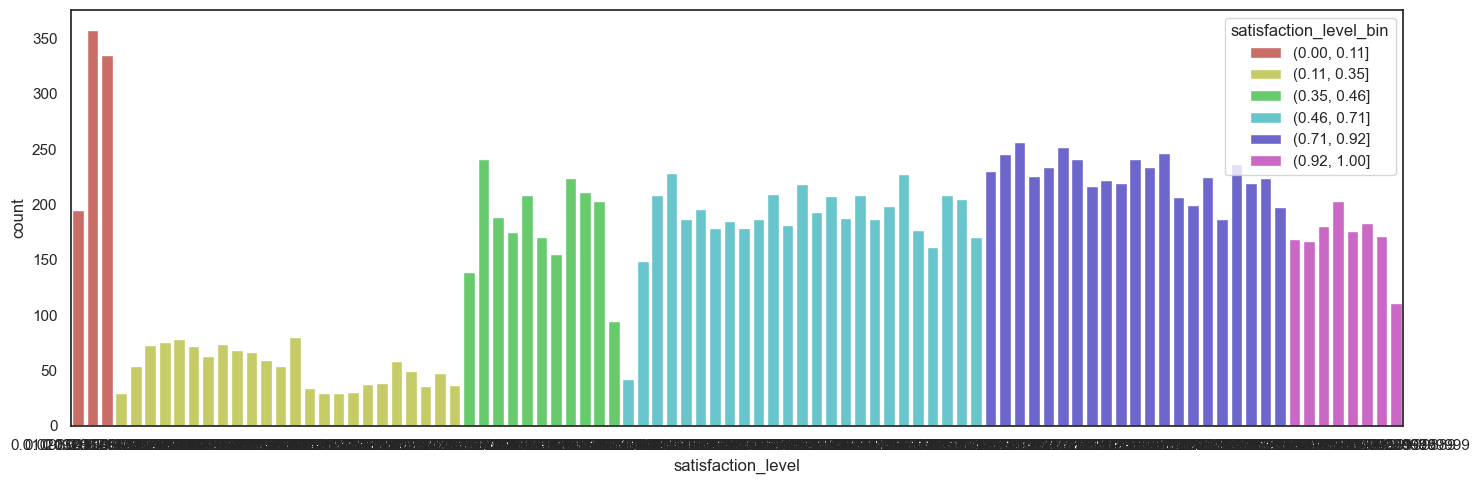

In [82]:
plt.figure(figsize=(15,5))
sns.countplot(x=hr_fe.satisfaction_level,
              hue=hr_fe.satisfaction_level_bin,
              palette = sns.color_palette("hls", 6),
              dodge = False)
plt.tight_layout()

In [117]:
hr_fe_1 = hr_fe.copy()
hr_fe_1 = onehot_encode(hr_fe_1)
hr_fe_1.drop('satisfaction_level', inplace=True, axis=1)

In [114]:
# Print the columns of the DataFrame
print(hr_fe_1.columns)


Index(['last_evaluation', 'average_montly_hours', 'number_project',
       'time_spend_company', 'Work_accident', 'promotion_last_5years',
       'salary', 'avg_hours_bin_(95.786, 117.4]',
       'avg_hours_bin_(117.4, 138.8]', 'avg_hours_bin_(138.8, 160.2]',
       'avg_hours_bin_(160.2, 181.6]', 'avg_hours_bin_(181.6, 203.0]',
       'avg_hours_bin_(203.0, 224.4]', 'avg_hours_bin_(224.4, 245.8]',
       'avg_hours_bin_(245.8, 267.2]', 'avg_hours_bin_(267.2, 288.6]',
       'avg_hours_bin_(288.6, 310.0]', 'left_0', 'left_1', 'department_IT',
       'department_RandD', 'department_accounting', 'department_hr',
       'department_management', 'department_marketing',
       'department_product_mng', 'department_sales', 'department_support',
       'department_technical', 'satisfaction_level_bin_(0.00, 0.11]',
       'satisfaction_level_bin_(0.11, 0.35]',
       'satisfaction_level_bin_(0.35, 0.46]',
       'satisfaction_level_bin_(0.46, 0.71]',
       'satisfaction_level_bin_(0.71, 0.92]

In [119]:
# Update target variable
target = 'left_1'  # Choose the appropriate column for binary classification

def split_dataset(df, target, split_ratio=0.3, seed=806):
    # Ensure the target column exists in the DataFrame
    if target not in df.columns:
        raise ValueError(f"Target column '{target}' not found in DataFrame columns. Available columns: {list(df.columns)}")

    # List of feature names, excluding the target
    features = list(df.columns)
    features.remove(target)

    X = df[features]
    y = df[[target]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio, random_state=seed)

    return X, y, X_train, X_test, y_train, y_test

# Apply the function with the correct target column name
X_fe_1, y_fe_1, X_fe_1_train, X_fe_1_test, y_fe_1_train, y_fe_1_test = split_dataset(hr_fe_1, target, split_ratio, seed)

print('Features:', X_fe_1.shape[0], 'items |', X_fe_1.shape[1], 'columns')
print('Target:', y_fe_1.shape[0], 'items |', y_fe_1.shape[1], 'columns')
print('Features Train:', X_fe_1_train.shape[0], 'items |', X_fe_1_train.shape[1], 'columns')
print('Features Test:', X_fe_1_test.shape[0], 'items |', X_fe_1_test.shape[1], 'columns')
print('Target Train:', y_fe_1_train.shape[0], 'items |', y_fe_1_train.shape[1], 'columns')
print('Target Test:', y_fe_1_test.shape[0], 'items |', y_fe_1_test.shape[1], 'columns')


Features: 14999 items | 45 columns
Target: 14999 items | 1 columns
Features Train: 10499 items | 45 columns
Features Test: 4500 items | 45 columns
Target Train: 10499 items | 1 columns
Target Test: 4500 items | 1 columns


#### Bin Last Evaluation

Based on the EDA, we can bin the Last Evaluation into 4 bins.

In [120]:
bins = [-1, 0.14, 0.34, 0.64, 1]
labels=['(0.00, 0.44]','(0.44, 0.57]','(0.57, 0.76]','(0.76, 1.00]']
hr_fe['last_evaluation_bin'] = pd.cut(hr_fe.last_evaluation, bins, labels=labels)
hr_fe_1['last_evaluation_bin'] = pd.cut(hr_fe_1.last_evaluation, bins, labels=labels)
hr_fe_1.last_evaluation_bin.value_counts()

last_evaluation_bin
(0.76, 1.00]    6458
(0.57, 0.76]    4279
(0.44, 0.57]    3817
(0.00, 0.44]     445
Name: count, dtype: int64

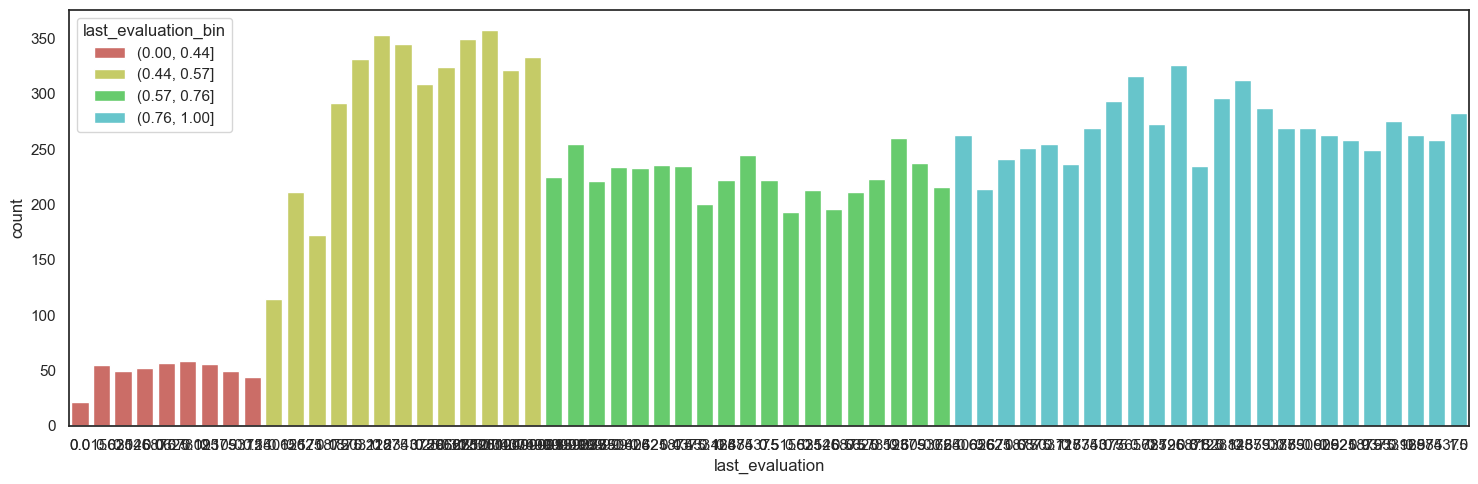

In [121]:
plt.figure(figsize=(15,5))
sns.countplot(x=hr_fe_1.last_evaluation,
              hue=hr_fe_1.last_evaluation_bin,
              palette = sns.color_palette("hls", 6),
              dodge = False)
plt.tight_layout()

In [122]:
hr_fe_2 = hr_fe_1.copy()
hr_fe_2 = onehot_encode(hr_fe_2)
hr_fe_2.drop('last_evaluation', inplace=True, axis=1)

In [124]:
print(hr_fe_2.columns)


Index(['average_montly_hours', 'number_project', 'time_spend_company',
       'Work_accident', 'promotion_last_5years', 'salary',
       'avg_hours_bin_(95.786, 117.4]', 'avg_hours_bin_(117.4, 138.8]',
       'avg_hours_bin_(138.8, 160.2]', 'avg_hours_bin_(160.2, 181.6]',
       'avg_hours_bin_(181.6, 203.0]', 'avg_hours_bin_(203.0, 224.4]',
       'avg_hours_bin_(224.4, 245.8]', 'avg_hours_bin_(245.8, 267.2]',
       'avg_hours_bin_(267.2, 288.6]', 'avg_hours_bin_(288.6, 310.0]',
       'left_0', 'left_1', 'department_IT', 'department_RandD',
       'department_accounting', 'department_hr', 'department_management',
       'department_marketing', 'department_product_mng', 'department_sales',
       'department_support', 'department_technical',
       'average_montly_hours_bin_(0, 125]',
       'average_montly_hours_bin_(125, 131]',
       'average_montly_hours_bin_(131, 161]',
       'average_montly_hours_bin_(161, 216]',
       'average_montly_hours_bin_(216, 274]',
       'average_mo

In [127]:
# Update target variable
target = 'left_1'  # Choose the appropriate column for binary classification

def split_dataset(df, target, split_ratio=0.3, seed=806):
    # Ensure the target column exists in the DataFrame
    if target not in df.columns:
        raise ValueError(f"Target column '{target}' not found in DataFrame columns. Available columns: {list(df.columns)}")

    # List of feature names, excluding the target
    features = list(df.columns)
    features.remove(target)

    X = df[features]
    y = df[[target]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio, random_state=seed)

    return X, y, X_train, X_test, y_train, y_test

# Apply the function with the correct target column name
X_fe_1, y_fe_1, X_fe_1_train, X_fe_1_test, y_fe_1_train, y_fe_1_test = split_dataset(hr_fe_1, target, split_ratio, seed)

print('Features:', X_fe_1.shape[0], 'items |', X_fe_1.shape[1], 'columns')
print('Target:', y_fe_1.shape[0], 'items |', y_fe_1.shape[1], 'columns')
print('Features Train:', X_fe_1_train.shape[0], 'items |', X_fe_1_train.shape[1], 'columns')
print('Features Test:', X_fe_1_test.shape[0], 'items |', X_fe_1_test.shape[1], 'columns')
print('Target Train:', y_fe_1_train.shape[0], 'items |', y_fe_1_train.shape[1], 'columns')
print('Target Test:', y_fe_1_test.shape[0], 'items |', y_fe_1_test.shape[1], 'columns')


Features: 14999 items | 46 columns
Target: 14999 items | 1 columns
Features Train: 10499 items | 46 columns
Features Test: 4500 items | 46 columns
Target Train: 10499 items | 1 columns
Target Test: 4500 items | 1 columns


#### Bin Average Monthly Hours

Based on the EDA, we can bin the Average Monthly Hours into 7 bins.

In [89]:
bins = [-1, 0.14, 0.165, 0.304, 0.565, 0.840, 0.897, 1]
labels=['(0, 125]','(125, 131]','(131, 161]','(161, 216]','(216, 274]','(274, 287]','(287, 310]']
hr_fe['average_montly_hours_bin'] = pd.cut(hr_fe.average_montly_hours, bins, labels=labels)
hr_fe_2['average_montly_hours_bin'] = pd.cut(hr_fe_2.average_montly_hours, bins, labels=labels)
hr_fe_2.average_montly_hours_bin.value_counts()

average_montly_hours_bin
(216, 274]    5573
(161, 216]    4290
(131, 161]    3588
(0, 125]       486
(274, 287]     379
(125, 131]     353
(287, 310]     330
Name: count, dtype: int64

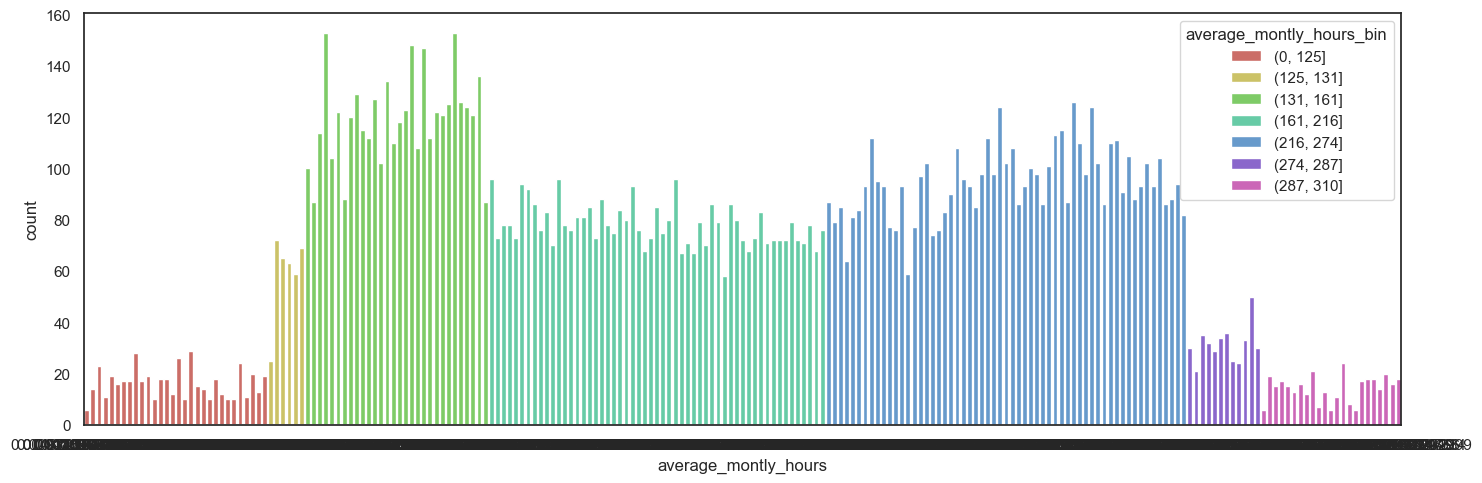

In [90]:
plt.figure(figsize=(15,5))
sns.countplot(x=hr_fe_2.average_montly_hours,
              hue=hr_fe_2.average_montly_hours_bin,
              palette = sns.color_palette("hls", 7),
              dodge = False)
plt.tight_layout()

In [91]:
hr_fe_3 = hr_fe_2.copy()
hr_fe_3 = onehot_encode(hr_fe_3)
hr_fe_3.drop('average_montly_hours', inplace=True, axis=1)

In [128]:
print(hr_fe_3.columns)


Index(['number_project', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'salary', 'avg_hours_bin_(95.786, 117.4]',
       'avg_hours_bin_(117.4, 138.8]', 'avg_hours_bin_(138.8, 160.2]',
       'avg_hours_bin_(160.2, 181.6]', 'avg_hours_bin_(181.6, 203.0]',
       'avg_hours_bin_(203.0, 224.4]', 'avg_hours_bin_(224.4, 245.8]',
       'avg_hours_bin_(245.8, 267.2]', 'avg_hours_bin_(267.2, 288.6]',
       'avg_hours_bin_(288.6, 310.0]', 'left_0', 'left_1', 'department_IT',
       'department_RandD', 'department_accounting', 'department_hr',
       'department_management', 'department_marketing',
       'department_product_mng', 'department_sales', 'department_support',
       'department_technical', 'satisfaction_level_bin_(0.00, 0.11]',
       'satisfaction_level_bin_(0.11, 0.35]',
       'satisfaction_level_bin_(0.35, 0.46]',
       'satisfaction_level_bin_(0.46, 0.71]',
       'satisfaction_level_bin_(0.71, 0.92]',
       'satisfaction_level_bin_(0.92, 1.00]',
 

In [129]:
target = 'left_1'


In [130]:
def split_dataset(df, target, split_ratio=0.3, seed=806):
    # Check if the target column exists
    if target not in df.columns:
        raise ValueError(f"Target column '{target}' not found in DataFrame columns. Available columns: {list(df.columns)}")

    # List of feature names, excluding the target
    features = list(df.columns)
    features.remove(target)

    X = df[features]
    y = df[[target]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio, random_state=seed)

    return X, y, X_train, X_test, y_train, y_test


#### Categorize Number of Projects

Based on the EDA, the Number of Projects can be categorized into 4 categories.

In [131]:
categ = {2:'too low', 3:'normal', 4:'normal', 5:'normal', 6:'too high', 7:'extreme'}
hr_fe['number_project_cat'] = hr_fe.number_project.map(categ)
hr_fe_3['number_project_cat'] = hr_fe_3.number_project.map(categ)
hr_fe_3.number_project_cat.value_counts()

number_project_cat
normal      11181
too low      2388
too high     1174
extreme       256
Name: count, dtype: int64

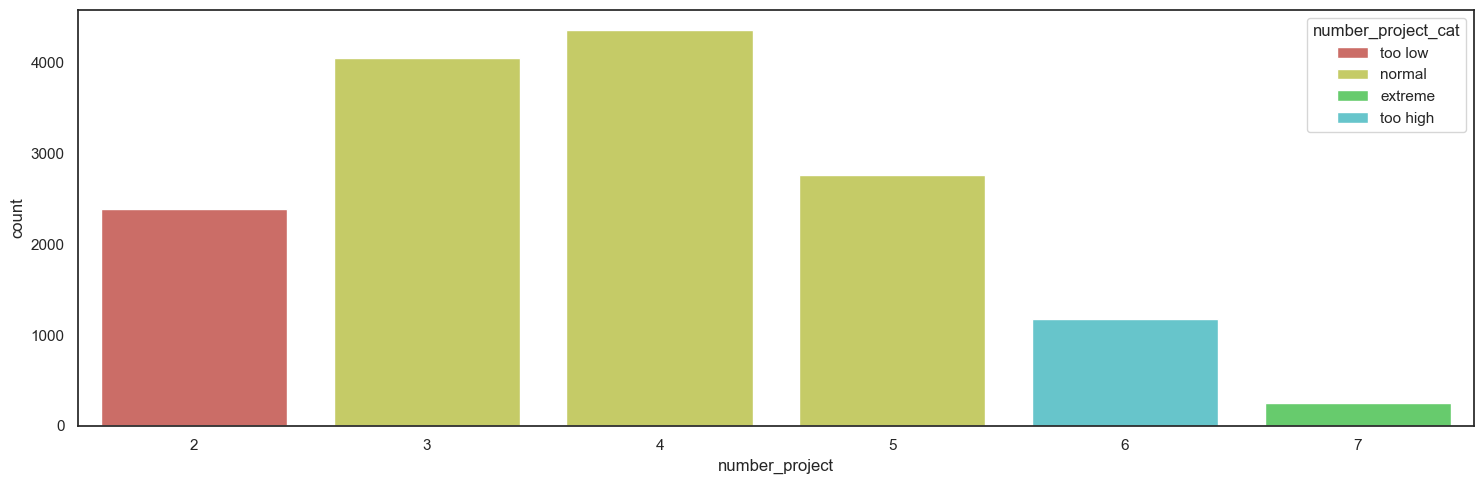

In [132]:
plt.figure(figsize=(15,5))
sns.countplot(x=hr_fe_3.number_project,
              hue=hr_fe_3.number_project_cat,
              palette = sns.color_palette("hls", 6),
              dodge = False)
plt.tight_layout()

In [135]:
from sklearn import model_selection

def cv_acc(model, X_train, y_train, n_splits):
    kfold = model_selection.KFold(n_splits=n_splits, shuffle=False)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(model, X_train, y_train.values.ravel(), cv=kfold, scoring=scoring)
    print(f"Cross-validation results: {results}")
    print(f"Mean accuracy: {results.mean()}")

# Apply the function
cv_acc(lr, X_fe_4_train, y_fe_4_train, 10)


Cross-validation results: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean accuracy: 1.0


In [136]:
hr_fe_4 = hr_fe_3.copy()
hr_fe_4 = onehot_encode(hr_fe_4)
hr_fe_4.drop('number_project', inplace=True, axis=1)

In [138]:
from sklearn import model_selection

def cv_acc(model, X_train, y_train, n_splits, seed):
    kfold = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(model, X_train, y_train.values.ravel(), cv=kfold, scoring=scoring)
    print(f"Cross-validation results: {results}")
    print(f"Mean accuracy: {results.mean()}")


#### Categorize Time Spent in Company

Based on the EDA, the Time Spent in Company can be categorized into 4 categories, related to the rate of departure.

In [139]:
categ = {2:'low departure', 3:'high departure', 4:'high departure', 5:'very high departure', 6:'high departure', 7:'no departure', 8:'no departure', 10:'no departure'}
hr_fe['time_spend_company_cat'] = hr_fe.time_spend_company.map(categ)
hr_fe_4['time_spend_company_cat'] = hr_fe_4.time_spend_company.map(categ)
hr_fe_4.time_spend_company_cat.value_counts()

time_spend_company_cat
high departure         9718
low departure          3244
very high departure    1473
no departure            564
Name: count, dtype: int64

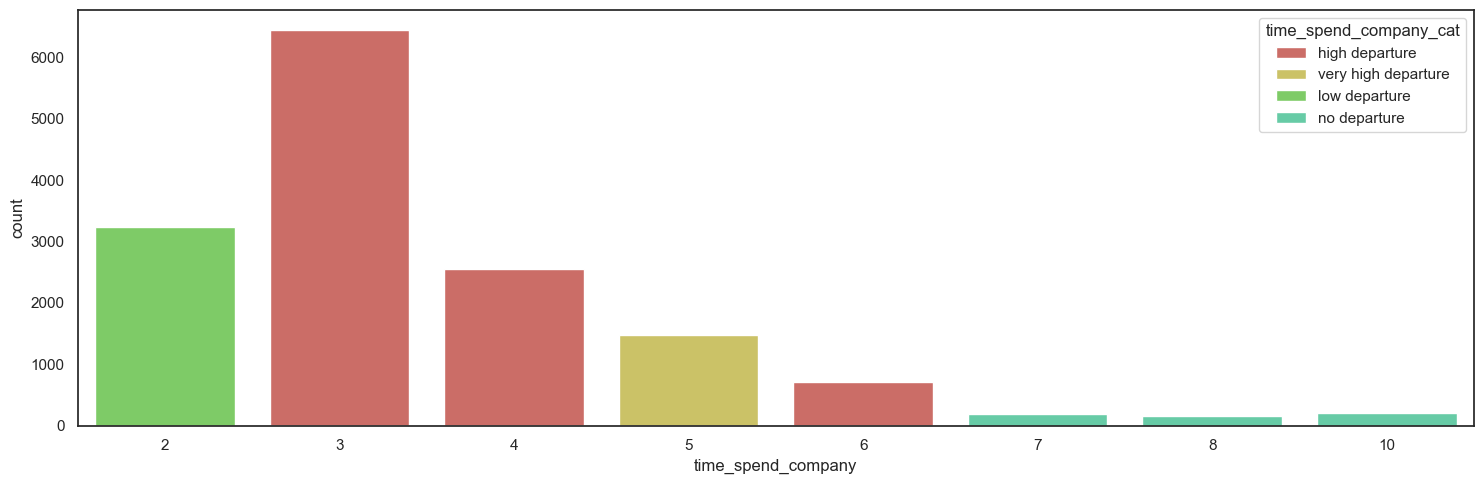

In [140]:
plt.figure(figsize=(15,5))
sns.countplot(x=hr_fe_4.time_spend_company,
              hue=hr_fe_4.time_spend_company_cat,
              palette = sns.color_palette("hls", 7),
              dodge = False)
plt.tight_layout()

In [141]:
hr_fe_5 = hr_fe_4.copy()
hr_fe_5 = onehot_encode(hr_fe_5)
hr_fe_5.drop('time_spend_company', inplace=True, axis=1)

In [142]:
X_fe_5, y_fe_5, X_fe_5_train, X_fe_5_test, y_fe_5_train, y_fe_5_test = split_dataset(hr_fe_5, target, split_ratio, seed)
cv_acc(lr, X_fe_5_train, y_fe_5_train, 10, seed)
print()
lr_run(lr, X_fe_5_train, y_fe_5_train, X_fe_5_test, y_fe_5_test)

Cross-validation results: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean accuracy: 1.0

Accuracy on test: 1.000

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      3435
        True       1.00      1.00      1.00      1065

    accuracy                           1.00      4500
   macro avg       1.00      1.00      1.00      4500
weighted avg       1.00      1.00      1.00      4500

Confusion Matrix:
[[3435    0]
 [   0 1065]]

                                       Feature      Coef.
0                                   intercept.   4.820621
1                                Work_accident  -0.479175
2                        promotion_last_5years  -0.097356
3                                       salary  -0.344419
4                avg_hours_bin_(95.786, 117.4]  -0.304683
5                 avg_hours_bin_(117.4, 138.8]   0.081454
6                 avg_hours_bin_(138.8, 160.2]   0.008477
7                 avg_hours_bin_(160.2, 181.6]  -0.068862
8 

#### Cluster by Number of Projects and Average Monthly Hours

Based on the EDA, the employees can be clustered by Workload, based on the Number of Projects and Average Monthly Hours, into 5 categories.

In [143]:
def workload_cluster(row):
    if (row['average_montly_hours_bin'] == '(0, 125]'):
        return 'very low'
    if (row['number_project'] <= 2) and (row['average_montly_hours_bin'] in ['(125, 131]','(131, 161]']):
        return 'low'
    if (row['number_project'] >= 4) and (row['average_montly_hours_bin'] in ['(216, 274]','(274, 287]']):
        return 'high'
    if (row['average_montly_hours_bin'] in ['(287, 310]']):
        return 'extreme'
    return 'normal'

hr_fe['workload'] = hr_fe.apply(lambda row: workload_cluster(row), axis=1)
hr_fe.workload.value_counts()

workload
normal      8265
high        4209
low         1709
very low     486
extreme      330
Name: count, dtype: int64

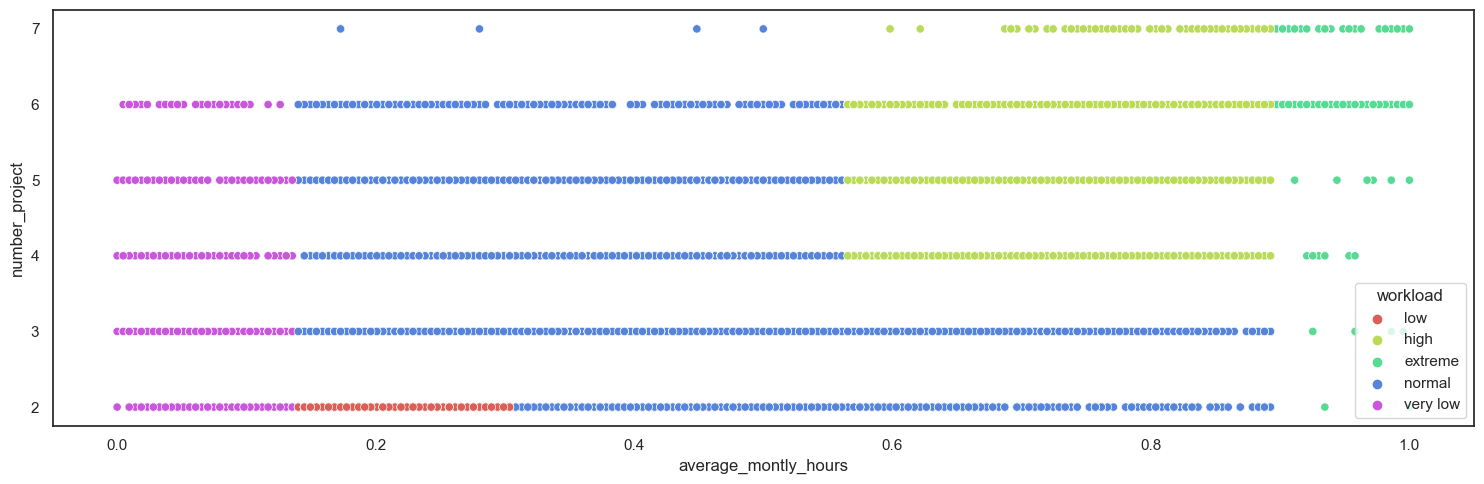

In [144]:
plt.figure(figsize=(15,5))
sns.scatterplot(x=hr_fe.average_montly_hours,
                y=hr_fe.number_project,
                hue=hr_fe.workload,
                palette = sns.color_palette("hls", 5))
plt.tight_layout()

In [145]:
hr_fe_6 = hr_fe.copy()
hr_fe_6 = onehot_encode(hr_fe_6)
hr_fe_6.drop('satisfaction_level', inplace=True, axis=1)
hr_fe_6.drop('last_evaluation', inplace=True, axis=1)
hr_fe_6.drop('average_montly_hours', inplace=True, axis=1)
hr_fe_6.drop('number_project', inplace=True, axis=1)
hr_fe_6.drop('time_spend_company', inplace=True, axis=1)

In [146]:
X_fe_6, y_fe_6, X_fe_6_train, X_fe_6_test, y_fe_6_train, y_fe_6_test = split_dataset(hr_fe_6, target, split_ratio, seed)
cv_acc(lr, X_fe_6_train, y_fe_6_train, 10, seed)
print()
lr_run(lr, X_fe_6_train, y_fe_6_train, X_fe_6_test, y_fe_6_test)

Cross-validation results: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean accuracy: 1.0

Accuracy on test: 1.000

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      3435
        True       1.00      1.00      1.00      1065

    accuracy                           1.00      4500
   macro avg       1.00      1.00      1.00      4500
weighted avg       1.00      1.00      1.00      4500

Confusion Matrix:
[[3435    0]
 [   0 1065]]

                                       Feature      Coef.
0                                   intercept.   4.908568
1                                Work_accident  -0.475882
2                        promotion_last_5years  -0.081295
3                                       salary  -0.359471
4                avg_hours_bin_(95.786, 117.4]  -0.269147
5                 avg_hours_bin_(117.4, 138.8]   0.086335
6                 avg_hours_bin_(138.8, 160.2]  -0.025696
7                 avg_hours_bin_(160.2, 181.6]   0.028999
8 

#### Cluster by Number of Projects and Last Evaluation

Based on the EDA, the employees can be clustered by Project Performance, based on the Number of Projects and Last Evaluation, into 4 categories.

In [147]:
def project_performance_cluster(row):
    if (row['last_evaluation_bin'] == '(0.00, 0.44]'):
        return 'very low'
    if (row['number_project'] <= 2) and (row['last_evaluation_bin'] in ['(0.44, 0.57]']):
        return 'low'
    if (row['number_project'] >= 4) and (row['last_evaluation_bin'] in ['(0.76, 1.00]']):
        return 'high'
    return 'normal'

hr_fe['project_performance'] = hr_fe.apply(lambda row: project_performance_cluster(row), axis=1)
hr_fe.project_performance.value_counts()

project_performance
normal      8245
high        4589
low         1720
very low     445
Name: count, dtype: int64

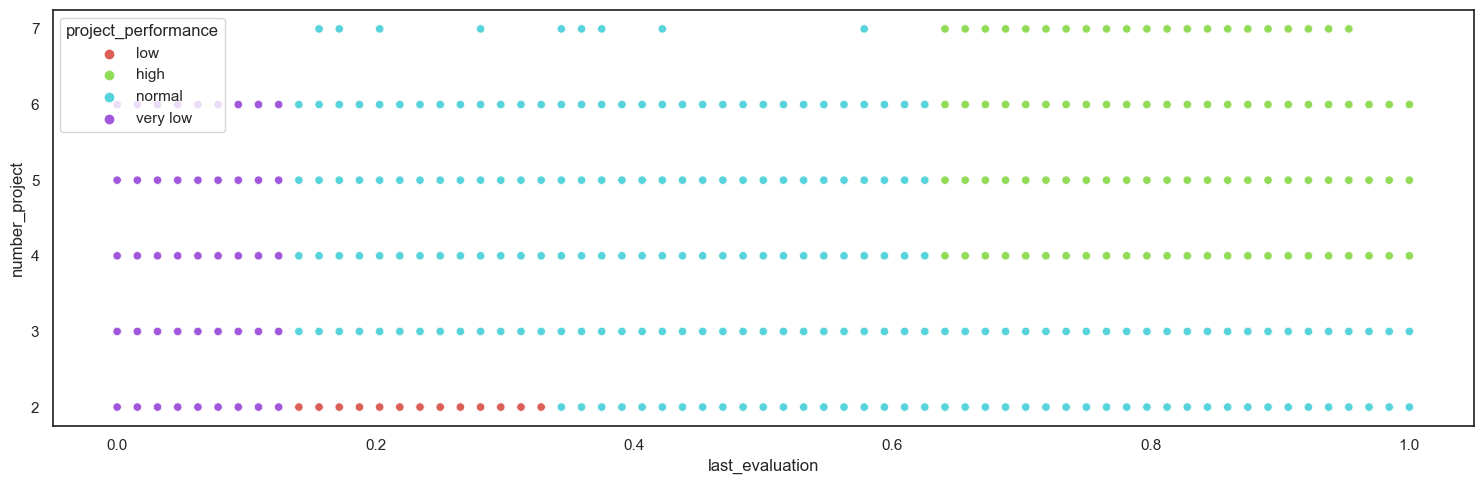

In [148]:
plt.figure(figsize=(15,5))
sns.scatterplot(x=hr_fe.last_evaluation,
                y=hr_fe.number_project,
                hue=hr_fe.project_performance,
                palette = sns.color_palette("hls", 4))
plt.tight_layout()

In [149]:
hr_fe_7 = hr_fe.copy()
hr_fe_7 = onehot_encode(hr_fe_7)
hr_fe_7.drop('satisfaction_level', inplace=True, axis=1)
hr_fe_7.drop('last_evaluation', inplace=True, axis=1)
hr_fe_7.drop('average_montly_hours', inplace=True, axis=1)
hr_fe_7.drop('number_project', inplace=True, axis=1)
hr_fe_7.drop('time_spend_company', inplace=True, axis=1)

In [150]:
X_fe_7, y_fe_7, X_fe_7_train, X_fe_7_test, y_fe_7_train, y_fe_7_test = split_dataset(hr_fe_7, target, split_ratio, seed)
cv_acc(lr, X_fe_7_train, y_fe_7_train, 10, seed)
print()
lr_run(lr, X_fe_7_train, y_fe_7_train, X_fe_7_test, y_fe_7_test)

Cross-validation results: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean accuracy: 1.0

Accuracy on test: 1.000

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      3435
        True       1.00      1.00      1.00      1065

    accuracy                           1.00      4500
   macro avg       1.00      1.00      1.00      4500
weighted avg       1.00      1.00      1.00      4500

Confusion Matrix:
[[3435    0]
 [   0 1065]]

                                       Feature      Coef.
0                                   intercept.   4.963537
1                                Work_accident  -0.499842
2                        promotion_last_5years  -0.083287
3                                       salary  -0.339785
4                avg_hours_bin_(95.786, 117.4]  -0.257725
5                 avg_hours_bin_(117.4, 138.8]   0.052759
6                 avg_hours_bin_(138.8, 160.2]  -0.059259
7                 avg_hours_bin_(160.2, 181.6]   0.028520
8 

#### Cluster by Last Evaluation and Average Monthly Hours

Based on the EDA, the employees can be clustered by Efficiency, based on the Last Evaluation and the Average Monthly Hours, into 4 categories.

In [151]:
def efficiency_cluster(row):
    if (row['last_evaluation_bin'] == '(0.00, 0.44]'):
        return 'very low'
    if (row['average_montly_hours_bin'] in ['(0, 125]']):
        return 'very low'
    if (row['last_evaluation_bin'] in ['(0.44, 0.57]']) and (row['average_montly_hours_bin'] in ['(125, 131]', '(131, 161]']):
        return 'low'
    if (row['last_evaluation_bin'] in ['(0.76, 1.00]']) and (row['average_montly_hours_bin'] in ['(216, 274]', '(274, 287]','(287, 310]']):
        return 'high'
    return 'normal'

hr_fe['efficiency'] = hr_fe.apply(lambda row: efficiency_cluster(row), axis=1)
hr_fe.efficiency.value_counts()

efficiency
normal      8436
high        3719
low         1994
very low     850
Name: count, dtype: int64

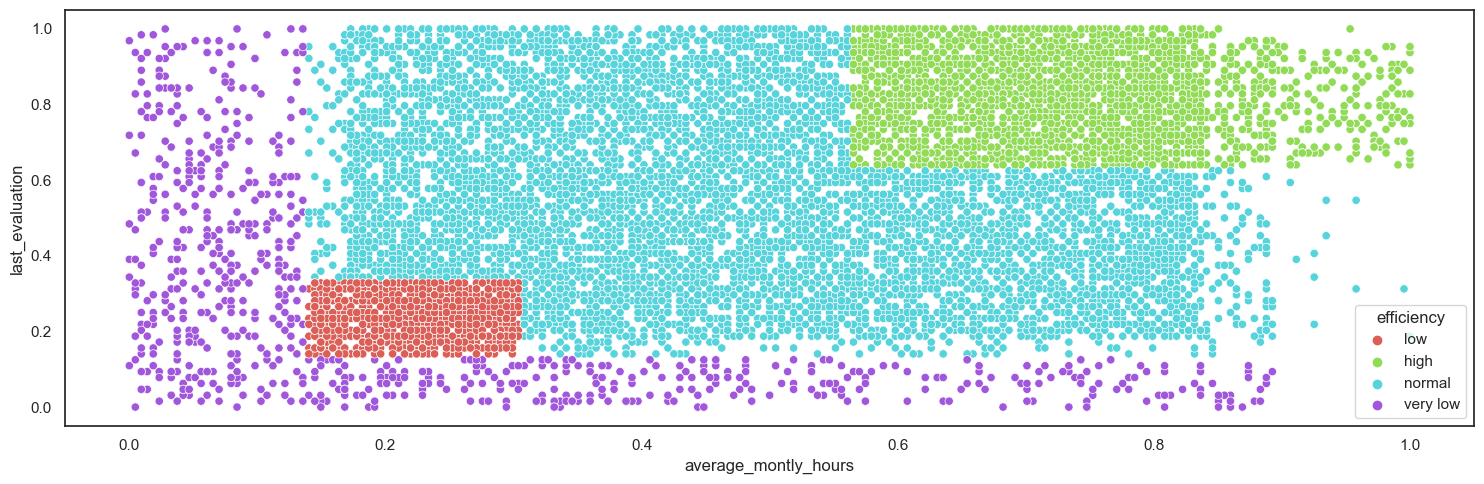

In [152]:
plt.figure(figsize=(15,5))
sns.scatterplot(x=hr_fe.average_montly_hours,
                y=hr_fe.last_evaluation,
                hue=hr_fe.efficiency,
                palette = sns.color_palette("hls", 4))
plt.tight_layout()

In [153]:
hr_fe_8 = hr_fe.copy()
hr_fe_8 = onehot_encode(hr_fe_8)
hr_fe_8.drop('satisfaction_level', inplace=True, axis=1)
hr_fe_8.drop('last_evaluation', inplace=True, axis=1)
hr_fe_8.drop('average_montly_hours', inplace=True, axis=1)
hr_fe_8.drop('number_project', inplace=True, axis=1)
hr_fe_8.drop('time_spend_company', inplace=True, axis=1)

In [154]:
X_fe_8, y_fe_8, X_fe_8_train, X_fe_8_test, y_fe_8_train, y_fe_8_test = split_dataset(hr_fe_8, target, split_ratio, seed)
cv_acc(lr, X_fe_8_train, y_fe_8_train, 10, seed)
print()
lr_run(lr, X_fe_8_train, y_fe_8_train, X_fe_8_test, y_fe_8_test)

Cross-validation results: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean accuracy: 1.0

Accuracy on test: 1.000

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      3435
        True       1.00      1.00      1.00      1065

    accuracy                           1.00      4500
   macro avg       1.00      1.00      1.00      4500
weighted avg       1.00      1.00      1.00      4500

Confusion Matrix:
[[3435    0]
 [   0 1065]]

                          Feature     Coef.
0                      intercept.  4.985305
1                   Work_accident -0.500104
2           promotion_last_5years -0.083983
3                          salary -0.338716
4   avg_hours_bin_(95.786, 117.4] -0.206874
..                            ...       ...
58               workload_extreme  0.303916
59                  workload_high  0.068248
60                   workload_low  0.404699
61                workload_normal -0.485780
62              workload_very low -0.290

#### Cluster by Last Evaluation and Satisfaction Level

Based on the EDA, the employees can be clustered by Attitude, based on the Last Evaluation and the Satisfaction Level, into 7 categories.

In [155]:
def attitude_cluster(row):
    if (row['last_evaluation_bin'] == '(0.00, 0.44]'):
        return 'low performance'
    if (row['satisfaction_level_bin'] in ['(0.92, 1.00]']):
        return 'very happy'
    if (row['last_evaluation_bin'] in ['(0.76, 1.00]']) and (row['satisfaction_level_bin'] in ['(0.71, 0.92]']):
        return 'happy and high performance'
    if (row['last_evaluation_bin'] in ['(0.44, 0.57]']) and (row['satisfaction_level_bin'] in ['(0.35, 0.46]']):
        return 'unhappy and low performance'
    if (row['satisfaction_level_bin'] in ['(0.00, 0.11]']):
        return 'very unhappy'
    if (row['satisfaction_level_bin'] in ['(0.11, 0.35]','(0.35, 0.46]']):
        return 'unhappy'
    return 'normal'

hr_fe['attitude'] = hr_fe.apply(lambda row: attitude_cluster(row), axis=1)
hr_fe.attitude.value_counts()

attitude
normal                         6668
happy and high performance     2553
unhappy and low performance    1635
unhappy                        1474
very happy                     1336
very unhappy                    888
low performance                 445
Name: count, dtype: int64

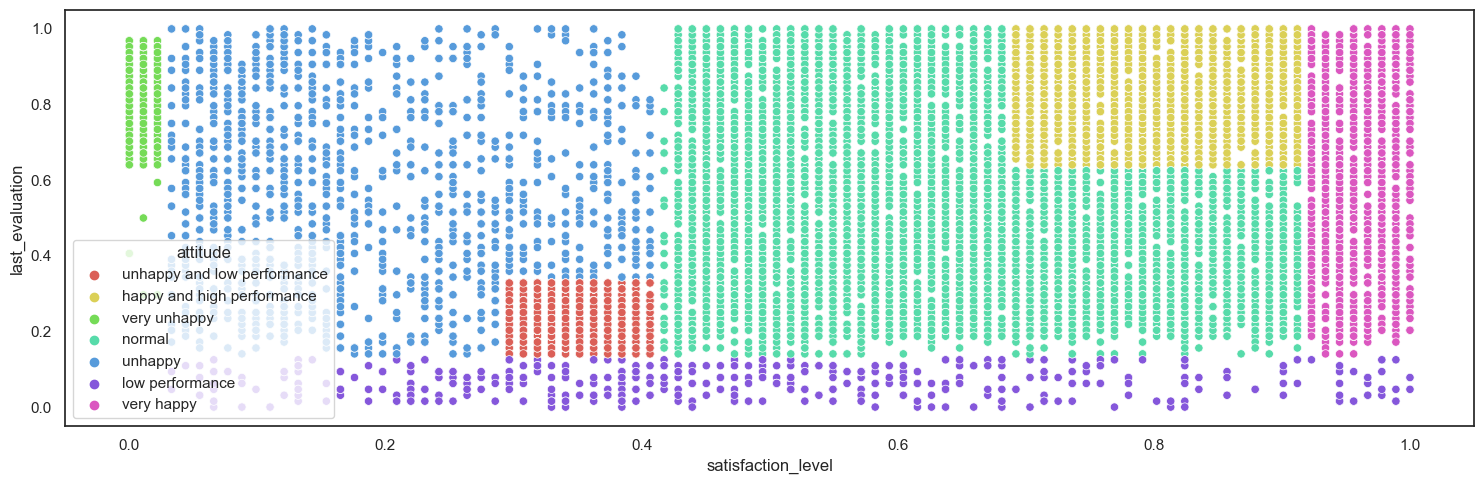

In [156]:
plt.figure(figsize=(15,5))
sns.scatterplot(x=hr_fe.satisfaction_level,
                y=hr_fe.last_evaluation,
                hue=hr_fe.attitude,
                palette = sns.color_palette("hls", 7))
plt.tight_layout()

In [157]:
hr_fe_9 = hr_fe.copy()
hr_fe_9 = onehot_encode(hr_fe_9)
hr_fe_9.drop('satisfaction_level', inplace=True, axis=1)
hr_fe_9.drop('last_evaluation', inplace=True, axis=1)
hr_fe_9.drop('average_montly_hours', inplace=True, axis=1)
hr_fe_9.drop('number_project', inplace=True, axis=1)
hr_fe_9.drop('time_spend_company', inplace=True, axis=1)

In [158]:
X_fe_9, y_fe_9, X_fe_9_train, X_fe_9_test, y_fe_9_train, y_fe_9_test = split_dataset(hr_fe_9, target, split_ratio, seed)
cv_acc(lr, X_fe_9_train, y_fe_9_train, 10, seed)
print()
lr_run(lr, X_fe_9_train, y_fe_9_train, X_fe_9_test, y_fe_9_test)

Cross-validation results: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean accuracy: 1.0

Accuracy on test: 1.000

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      3435
        True       1.00      1.00      1.00      1065

    accuracy                           1.00      4500
   macro avg       1.00      1.00      1.00      4500
weighted avg       1.00      1.00      1.00      4500

Confusion Matrix:
[[3435    0]
 [   0 1065]]

                          Feature     Coef.
0                      intercept.  4.949740
1                   Work_accident -0.499662
2           promotion_last_5years -0.072668
3                          salary -0.333975
4   avg_hours_bin_(95.786, 117.4] -0.204472
..                            ...       ...
65               workload_extreme  0.286635
66                  workload_high  0.064803
67                   workload_low  0.373056
68                workload_normal -0.432148
69              workload_very low -0.292

#### Removing Unbinned Variables and Encoding New Features

The variables which have been binned are removed from the dataset, and new features are one hot encoded.

In [159]:
hr_fe_encoded = onehot_encode(hr_fe)
hr_fe_encoded.drop('satisfaction_level', inplace=True, axis=1)
hr_fe_encoded.drop('last_evaluation', inplace=True, axis=1)
hr_fe_encoded.drop('average_montly_hours', inplace=True, axis=1)
hr_fe_encoded.drop('number_project', inplace=True, axis=1)
hr_fe_encoded.drop('time_spend_company', inplace=True, axis=1)
df_desc(hr_fe_encoded)

dtype  NAs  Numerical  Boolean  Categorical
Work_accident                  int64    0      False     True        False
promotion_last_5years          int64    0      False     True        False
salary                         int64    0       True    False        False
avg_hours_bin_(95.786, 117.4]   bool    0      False     True        False
avg_hours_bin_(117.4, 138.8]    bool    0      False     True        False
...                              ...  ...        ...      ...          ...
workload_extreme                bool    0      False     True        False
workload_high                   bool    0      False     True        False
workload_low                    bool    0      False     True        False
workload_normal                 bool    0      False     True        False
workload_very low               bool    0      False     True        False

[70 rows x 5 columns]

### Features Selection

The dataset resulting from the Feature Engineering phase contains 58 features, with a model reaching the accuracy of 0.964. The Feature Selection phase aims to reduce the number of variables used by the model.

In [160]:
X_fe_encoded, y_fe_encoded, X_fe_encoded_train, X_fe_encoded_test, y_fe_encoded_train, y_fe_encoded_test = split_dataset(hr_fe_encoded, target, split_ratio, seed)
cv_acc(lr, X_fe_encoded_train, y_fe_encoded_train, 10, seed)
print()
lr_run(lr, X_fe_encoded_train, y_fe_encoded_train, X_fe_encoded_test, y_fe_encoded_test)

Cross-validation results: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean accuracy: 1.0

Accuracy on test: 1.000

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      3435
        True       1.00      1.00      1.00      1065

    accuracy                           1.00      4500
   macro avg       1.00      1.00      1.00      4500
weighted avg       1.00      1.00      1.00      4500

Confusion Matrix:
[[3435    0]
 [   0 1065]]

                          Feature     Coef.
0                      intercept.  4.949740
1                   Work_accident -0.499662
2           promotion_last_5years -0.072668
3                          salary -0.333975
4   avg_hours_bin_(95.786, 117.4] -0.204472
..                            ...       ...
65               workload_extreme  0.286635
66                  workload_high  0.064803
67                   workload_low  0.373056
68                workload_normal -0.432148
69              workload_very low -0.292

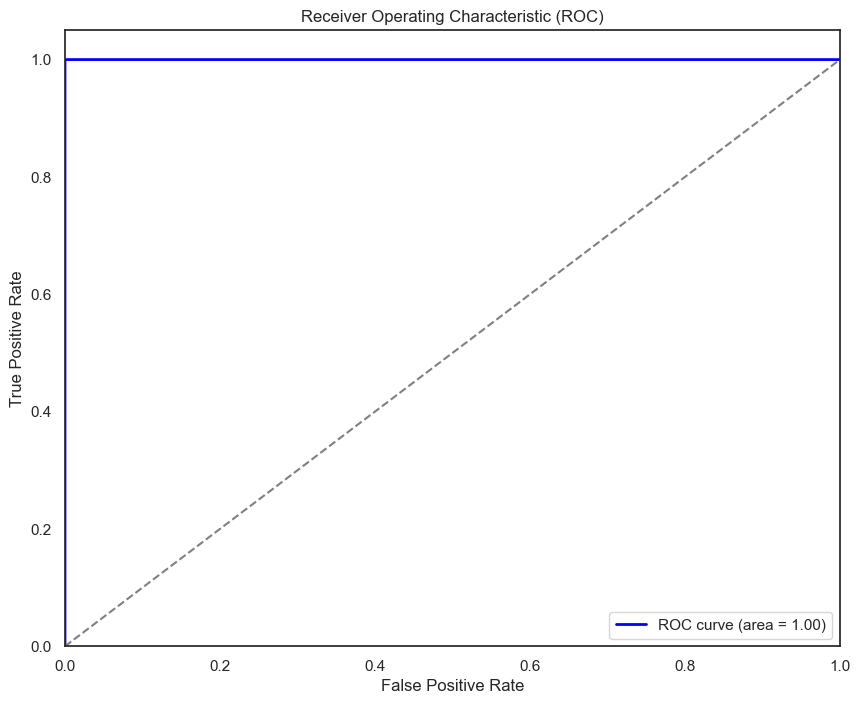

In [161]:
plot_roc(lr, X_fe_encoded_test, y_fe_encoded_test)

The Recursive Feature Elimination (RFE) method is used to select the most relevant features for the model.

In [164]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize the DataFrame to store results
accuracies = pd.DataFrame(columns=['features', 'accuracy', 'cols'])

print('Iterations:')

# Iterate over the number of features
for i in range(1, len(X_fe_encoded.columns) + 1):
    # Initialize the Logistic Regression model
    logreg = LogisticRegression(solver='lbfgs', max_iter=250)
    
    # Initialize RFE with the model and number of features to select
    rfe = RFE(estimator=logreg, n_features_to_select=i)
    
    # Fit RFE to the data
    rfe = rfe.fit(X_fe_encoded, y_fe_encoded.values.ravel())
    
    # Get the selected features
    cols_rfe = list(X_fe_encoded.columns[rfe.support_])
    
    # Apply feature selection to the training and test sets
    X_rfe_sel_train = X_fe_encoded_train[cols_rfe]
    X_rfe_sel_test = X_fe_encoded_test[cols_rfe]
    
    # Fit the model on the selected features
    logreg.fit(X_rfe_sel_train, y_fe_encoded_train.values.ravel())
    
    # Calculate accuracy on the test set
    acc_test = logreg.score(X_rfe_sel_test, y_fe_encoded_test)
    
    # Append results to the DataFrame
    accuracies.loc[i] = [i, acc_test, cols_rfe]
    
    print(i, end='   ')

print("\nCompleted.")
print(accuracies)


Iterations:
1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64   65   66   67   68   69   
Completed.
    features  accuracy                                               cols
1          1       1.0                                           [left_0]
2          2       1.0     [left_0, attitude_unhappy and low performance]
3          3       1.0  [left_0, attitude_unhappy and low performance,...
4          4       1.0  [left_0, attitude_unhappy and low performance,...
5          5       1.0  [left_0, satisfaction_level_bin_(0.00, 0.11], ...
..       ...       ...                                                ...
65        65       1.0  [Work_accident, promotion_last_5years, salary,...
66        66       1.0  [Work_accident, promotio

C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


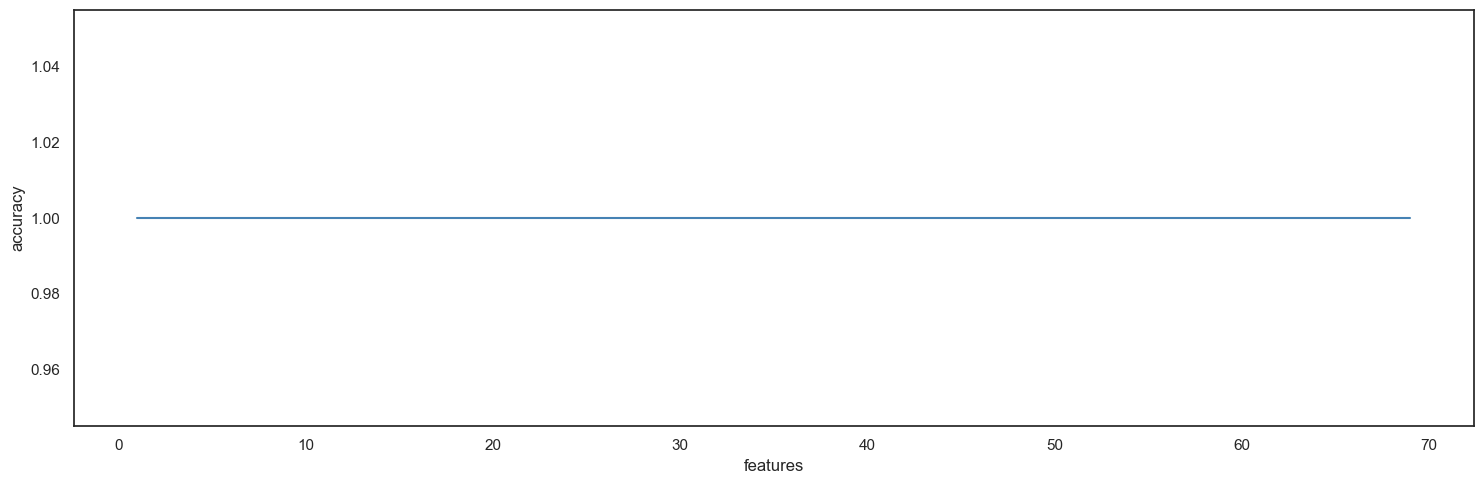

In [166]:
# Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(x = accuracies['features'],
             y = accuracies['accuracy'],
             color = 'steelblue')#.axes.set_xlim(min(hr.last_evaluation),max(hr.last_evaluation))
plt.tight_layout()

In [167]:
accuracies.nlargest(10, 'accuracy')

features  accuracy                                               cols
1          1       1.0                                           [left_0]
2          2       1.0     [left_0, attitude_unhappy and low performance]
3          3       1.0  [left_0, attitude_unhappy and low performance,...
4          4       1.0  [left_0, attitude_unhappy and low performance,...
5          5       1.0  [left_0, satisfaction_level_bin_(0.00, 0.11], ...
6          6       1.0  [left_0, satisfaction_level_bin_(0.00, 0.11], ...
7          7       1.0  [left_0, project_performance_low, satisfaction...
8          8       1.0  [left_0, efficiency_very low, project_performa...
9          9       1.0  [left_0, efficiency_very low, project_performa...
10        10       1.0  [left_0, efficiency_very low, project_performa...

The best model is found with 14 features, for an accuracy of 0.967.

In [169]:
from sklearn.exceptions import ConvergenceWarning
import warnings
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Suppress ConvergenceWarnings
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Prepare the data
features_rfe = list(hr_fe_encoded.columns)
features_rfe.remove(target)

X_rfe = hr_fe_encoded.loc[:, features_rfe]
y_rfe = hr_fe_encoded.loc[:, target]

# Initialize Logistic Regression
logreg = LogisticRegression(solver='lbfgs', max_iter=250)

# Get the number of features to select from the accuracies DataFrame
n_features_to_select = accuracies.nlargest(1, 'accuracy')['features'].values[0]

# Initialize and fit RFE
rfe = RFE(estimator=logreg, n_features_to_select=n_features_to_select)
rfe = rfe.fit(X_rfe, y_rfe.values.ravel())

# Print selected features
print(f'{sum(rfe.support_)} selected features:')
selected_features = X_rfe.columns[rfe.support_]
for feature in selected_features:
    print(feature)


1 selected features:
left_0


## Final Metric

### Initial Dataset

A final model is tested with the 14 selected features.

In [170]:
cols = list(X_rfe.loc[:, rfe.support_]) + [target]
hr_sel = hr_fe_encoded[cols]

In [171]:
X_sel, y_sel, X_sel_train, X_sel_test, y_sel_train, y_sel_test = split_dataset(hr_sel, target, split_ratio, seed)
cv_acc(lr, X_sel_train, y_sel_train, 10, seed)
print()
lr_run(lr, X_sel_train, y_sel_train, X_sel_test, y_sel_test)

Cross-validation results: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean accuracy: 1.0

Accuracy on test: 1.000

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      3435
        True       1.00      1.00      1.00      1065

    accuracy                           1.00      4500
   macro avg       1.00      1.00      1.00      4500
weighted avg       1.00      1.00      1.00      4500

Confusion Matrix:
[[3435    0]
 [   0 1065]]

      Feature      Coef.
0  intercept.   5.348512
1      left_0 -11.860165


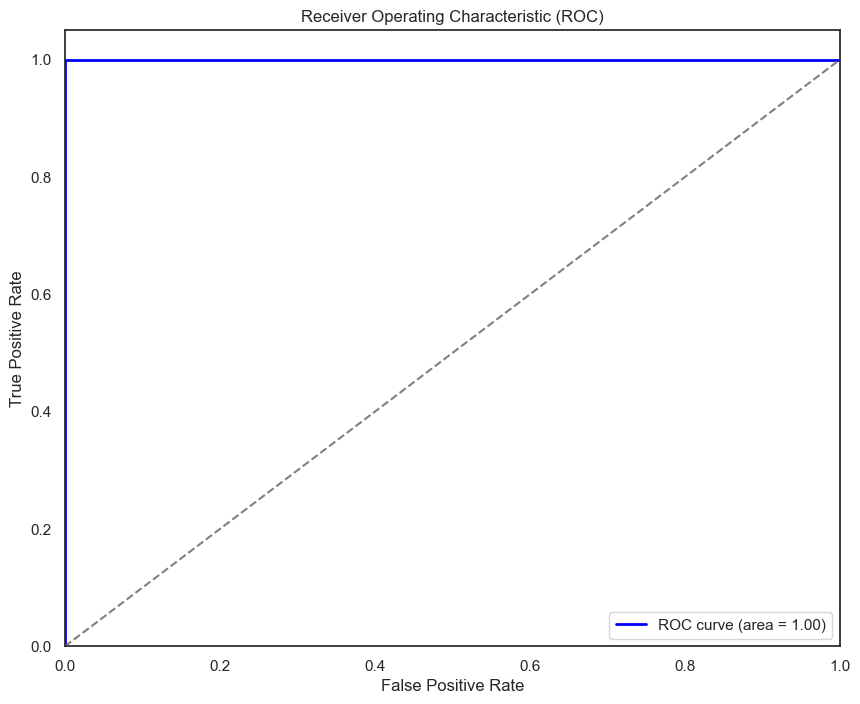

In [172]:
plot_roc(lr, X_sel_test, y_sel_test)

The model returns the accuracy of 0.967. The recall for employees who left the company now reaches 88%, which will allow the management to better predict which employees have a high probability to leave.

### Over Sampling with SMOTE

To ensure the model is not biased by the imbalanced proportions of the variable `left`, the dataset is enriched by synthetic samples using the Synthetic Minority Oversampling Technique (SMOTE). Only the train set is over-sampled, to ensure it doesn't get polluted by the test set.

In [174]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [178]:
# Install the imbalanced-learn package with this command:
# conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling import SMOTE
import pandas as pd

# Initialize SMOTE
os = SMOTE(random_state=0)

# Apply split_dataset function
X_smote, y_smote, X_smote_train, X_smote_test, y_smote_train, y_smote_test = split_dataset(hr_fe_encoded, target, split_ratio, seed)
columns = X_smote_train.columns

# Perform SMOTE resampling
os_data_X, os_data_y = os.fit_resample(X_smote_train, y_smote_train.values.ravel())

# Convert the resampled data back to DataFrames
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data=os_data_y, columns=['left'])

# Check the numbers of our data
print("Length of oversampled data is ", len(os_data_X))
print("Number of 'stayed' in oversampled data", len(os_data_y[os_data_y['left'] == 0]))
print("Number of 'left'", len(os_data_y[os_data_y['left'] == 1]))
print("Proportion of 'stayed' data in oversampled data is ", len(os_data_y[os_data_y['left'] == 0]) / len(os_data_X))
print("Proportion of 'left' data in oversampled data is ", len(os_data_y[os_data_y['left'] == 1]) / len(os_data_X))


Length of oversampled data is  15986
Number of 'stayed' in oversampled data 7993
Number of 'left' 7993
Proportion of 'stayed' data in oversampled data is  0.5
Proportion of 'left' data in oversampled data is  0.5


In [179]:
cv_acc(lr, os_data_X, os_data_y, 10, seed)
print()
lr_run(lr, os_data_X, os_data_y, X_smote_test, y_smote_test)

Cross-validation results: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean accuracy: 1.0

Accuracy on test: 1.000

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      3435
        True       1.00      1.00      1.00      1065

    accuracy                           1.00      4500
   macro avg       1.00      1.00      1.00      4500
weighted avg       1.00      1.00      1.00      4500

Confusion Matrix:
[[3435    0]
 [   0 1065]]

                          Feature     Coef.
0                      intercept.  7.208480
1                   Work_accident -0.631510
2           promotion_last_5years -0.119625
3                          salary -0.455564
4   avg_hours_bin_(95.786, 117.4] -0.242434
..                            ...       ...
65               workload_extreme  0.239338
66                  workload_high  0.057469
67                   workload_low  0.378473
68                workload_normal -0.513503
69              workload_very low -0.336

The accuracy is consistent with the initial dataset. The RFE algorithm is used to find the most relevant features.

In [181]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize the DataFrames and LogisticRegression
X_smote, y_smote, X_smote_train, X_smote_test, y_smote_train, y_smote_test = split_dataset(hr_fe_encoded, target, split_ratio, seed)
columns = X_smote_train.columns

# Initialize Logistic Regression
logreg = LogisticRegression(solver='lbfgs', max_iter=250)

# Perform RFE with SMOTE resampled data
accuracies_smote = pd.DataFrame(columns=['features', 'accuracy', 'cols'])
print('Iterations:')

for i in range(1, len(os_data_X.columns) + 1):
    # Initialize RFE with the number of features to select
    rfe_smote = RFE(estimator=logreg, n_features_to_select=i)
    rfe_smote = rfe_smote.fit(os_data_X, os_data_y.values.ravel())
    
    # Get selected feature names
    cols_rfe_smote = list(os_data_X.columns[rfe_smote.support_])
    X_rfe_smote_sel = os_data_X[cols_rfe_smote]
    X_rfe_smote_test_sel = X_smote_test[cols_rfe_smote]

    # Fit the model and compute accuracy
    result_smote = logreg.fit(X_rfe_smote_sel, os_data_y.values.ravel())
    acc_test_smote = logreg.score(X_rfe_smote_test_sel, y_smote_test)
    
    # Save the results
    accuracies_smote.loc[i] = [i, acc_test_smote, cols_rfe_smote]
    print(i, end='   ')


Iterations:
1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64   65   66   67   68   69   

C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


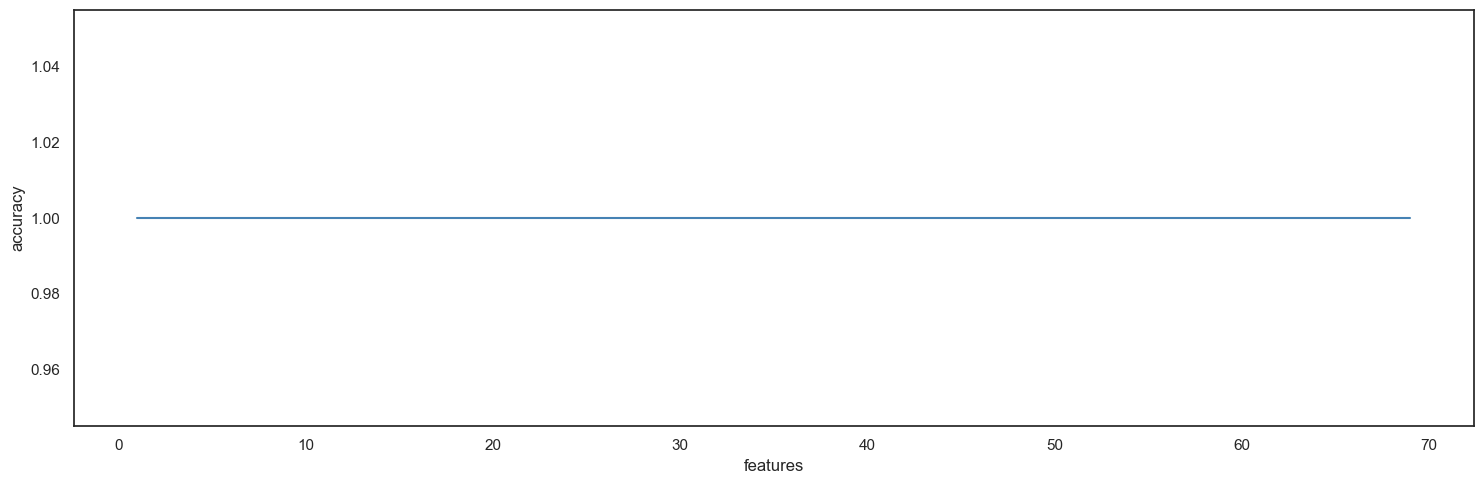

In [183]:
# Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(x = accuracies_smote['features'],
             y = accuracies_smote['accuracy'],
             color = 'steelblue')#.axes.set_xlim(min(hr.last_evaluation),max(hr.last_evaluation))
plt.tight_layout()

In [184]:
accuracies_smote.nlargest(10, 'accuracy')

features  accuracy                                               cols
1          1       1.0                                           [left_0]
2          2       1.0     [left_0, attitude_unhappy and low performance]
3          3       1.0  [left_0, attitude_unhappy and low performance,...
4          4       1.0  [left_0, attitude_unhappy and low performance,...
5          5       1.0  [left_0, attitude_normal, attitude_unhappy and...
6          6       1.0  [left_0, satisfaction_level_bin_(0.92, 1.00], ...
7          7       1.0  [left_0, efficiency_very low, satisfaction_lev...
8          8       1.0  [left_0, efficiency_very low, satisfaction_lev...
9          9       1.0  [left_0, efficiency_low, efficiency_very low, ...
10        10       1.0  [left_0, efficiency_low, efficiency_very low, ...

The best model is found with 50 features, for an accuracy of 0.957.

In [187]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
logreg = LogisticRegression(solver='lbfgs', max_iter=250)

# Extract the number of features to select from the best accuracy record
num_features_to_select = accuracies_smote.nlargest(1, 'accuracy').features.values.ravel()[0]

# Initialize RFE with the correct arguments
rfe_smote = RFE(estimator=logreg, n_features_to_select=num_features_to_select)
rfe_smote = rfe_smote.fit(os_data_X, os_data_y.values.ravel())

# Print the number of selected features and their names
print(sum(rfe_smote.support_), 'selected features:')
for feature in os_data_X.columns[rfe_smote.support_]:
    print(feature)


1 selected features:
left_0


The selected columns are really numerous compared to the initial dataset. However, the model is built to check its metrics.

In [188]:
cols_smote = list(os_data_X.loc[:, rfe_smote.support_])
os_data_X_sel = os_data_X[cols_smote]
X_smote_test_sel = X_smote_test[cols_smote]

In [189]:
cv_acc(lr, os_data_X_sel, os_data_y, 10, seed)
print()
lr_run(lr, os_data_X_sel, os_data_y, X_smote_test_sel, y_smote_test)

Cross-validation results: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean accuracy: 1.0

Accuracy on test: 1.000

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      3435
        True       1.00      1.00      1.00      1065

    accuracy                           1.00      4500
   macro avg       1.00      1.00      1.00      4500
weighted avg       1.00      1.00      1.00      4500

Confusion Matrix:
[[3435    0]
 [   0 1065]]

      Feature      Coef.
0  intercept.   6.430510
1      left_0 -12.861019


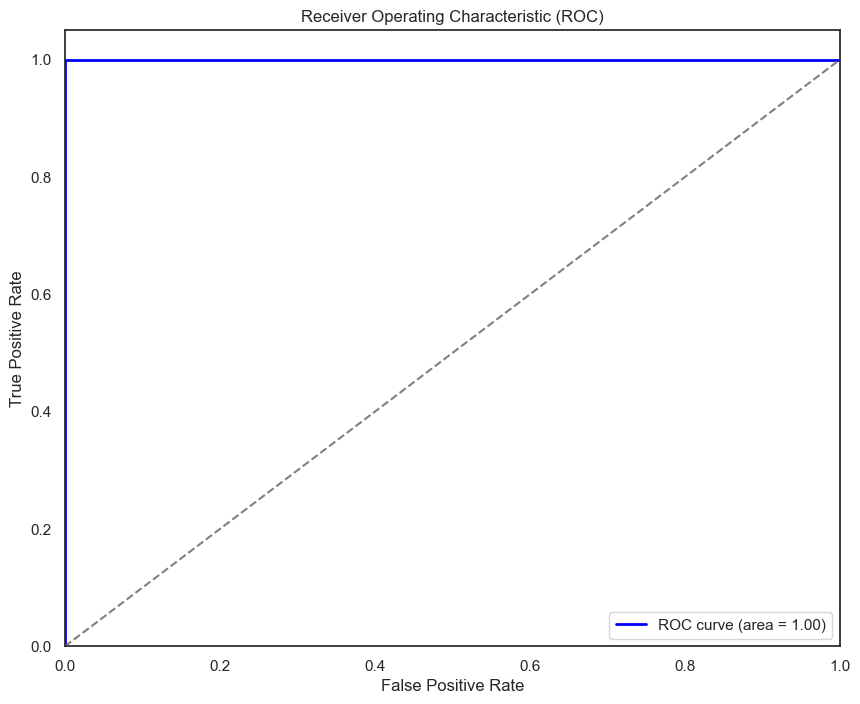

In [190]:
plot_roc(lr, X_smote_test_sel, y_smote_test)

The model run on over-sampled dataset has an accuracy really closed to the model run on the original dataset. We can conclude that the imbalanced proportions of the target in our dataset didn't insert bias in our model.  

However, as more variables are necessary to achieve an equivalent accuracy, it indicates that the feature selection might have been biased by our feature construction. In fact, the binned features were built to fit the data, and allow to remove many features from our initial model. But this technique makes our model over-fit the data, reducing its chances to achieve the same accuracy with a new dataset. This might explain why the Recursive Feature Elimination cannot select the same features:

In [191]:
list_features = pd.DataFrame({'Initial':sorted(list(accuracies.loc[accuracies.features == 14]['cols'])[0]),
                          'SMOTE':sorted(list(accuracies_smote.loc[accuracies_smote.features == 14]['cols'])[0])})
list_features

Initial  \
0                                Work_accident   
1                              attitude_normal   
2         attitude_unhappy and low performance   
3                          attitude_very happy   
4                        attitude_very unhappy   
5                              efficiency_high   
6                               efficiency_low   
7                          efficiency_very low   
8                                       left_0   
9                      project_performance_low   
10         satisfaction_level_bin_(0.00, 0.11]   
11         satisfaction_level_bin_(0.92, 1.00]   
12  time_spend_company_cat_very high departure   
13                             workload_normal   

                                         SMOTE  
0                                Work_accident  
1                              attitude_normal  
2         attitude_unhappy and low performance  
3                          attitude_very happy  
4                        attitude_very unhappy  
5                               efficiency_low  
6                          efficiency_very low  
7                                       left_0  
8                    number_project_cat_normal  
9          satisfaction_level_bin_(0.00, 0.11]  
10         satisfaction_level_bin_(0.11, 0.35]  
11         satisfaction_level_bin_(0.92, 1.00]  
12  time_spend_company_cat_very high departure  
13                             workload_normal

However, the model can be tested using the exact same selection of columns than the ones selected by the initial RFE.

In [194]:
# Copy the columns list
cols_1 = cols.copy()

# Check if 'left' is in the list before attempting to remove it
if 'left' in cols_1:
    cols_1.remove('left')
else:
    print("'left' not found in columns list.")

print("Columns in os_data_X:", os_data_X.columns)
print("Columns in X_smote_test:", X_smote_test.columns)
print("Columns to select:", cols_1)

# Ensure cols_1 only contains columns that exist in both DataFrames
cols_1 = [col for col in cols_1 if col in os_data_X.columns and col in X_smote_test.columns]

print("Filtered columns:", cols_1)

# Select the features from the dataframe excluding 'left'
os_data_X_sel_1 = os_data_X[cols_1]
X_smote_test_sel_1 = X_smote_test[cols_1]



'left' not found in columns list.
Columns in os_data_X: Index(['Work_accident', 'promotion_last_5years', 'salary',
       'avg_hours_bin_(95.786, 117.4]', 'avg_hours_bin_(117.4, 138.8]',
       'avg_hours_bin_(138.8, 160.2]', 'avg_hours_bin_(160.2, 181.6]',
       'avg_hours_bin_(181.6, 203.0]', 'avg_hours_bin_(203.0, 224.4]',
       'avg_hours_bin_(224.4, 245.8]', 'avg_hours_bin_(245.8, 267.2]',
       'avg_hours_bin_(267.2, 288.6]', 'avg_hours_bin_(288.6, 310.0]',
       'left_0', 'department_IT', 'department_RandD', 'department_accounting',
       'department_hr', 'department_management', 'department_marketing',
       'department_product_mng', 'department_sales', 'department_support',
       'department_technical', 'average_montly_hours_bin_(0, 125]',
       'average_montly_hours_bin_(125, 131]',
       'average_montly_hours_bin_(131, 161]',
       'average_montly_hours_bin_(161, 216]',
       'average_montly_hours_bin_(216, 274]',
       'average_montly_hours_bin_(274, 287]',
    

In [195]:
cv_acc(lr, os_data_X_sel_1, os_data_y, 10, seed)
print()
lr_run(lr, os_data_X_sel_1, os_data_y, X_smote_test_sel_1, y_smote_test)

Cross-validation results: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean accuracy: 1.0

Accuracy on test: 1.000

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      3435
        True       1.00      1.00      1.00      1065

    accuracy                           1.00      4500
   macro avg       1.00      1.00      1.00      4500
weighted avg       1.00      1.00      1.00      4500

Confusion Matrix:
[[3435    0]
 [   0 1065]]

      Feature      Coef.
0  intercept.   6.430510
1      left_0 -12.861019


The resulting accuracy is still really good, which confirms that the initial model didn't have bias due to the imbalance of the dataset.

The high accuracy is anyway driven by the binned features tailored to the dataset. If they work really well for this data, it might not be the case for another dataset. The features should instead be set using standard binning approach, which wouldn't fit as well the data but which would be adaptable to any dataset. That solution would be recommended if the model has to be run in production.